# Rule Finding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from itertools import groupby
from collections import Counter
# from jupyterthemes import jtplot
# jtplot.reset()
import os
import glob

In [2]:
""" Reads data in from all participants. The final virtual game data from 
In the Zone and Simon Says. Only takes data where the entry type = 0. 
python lists: 'InTheZone' and 'SimonSays'
"""

path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "../Data/All_Participants/InTheZone/*"))
InTheZone = []
print("In the Zone Paths:")

for i in csv_files:
    df = pd.read_csv(i)
    df = df[df['entryType'] == 0]
    InTheZone.append(df)
    print(i)
    
csv_files = glob.glob(os.path.join(path, "../Data/All_Participants/SimonSays/*"))
SimonSays = []
print("Simon Says Paths:")

for i in csv_files:
    df = pd.read_csv(i)
    df = df[df['entryType'] == 0]
    SimonSays.append(df)
    print(i)

In the Zone Paths:
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/32098021_VirtualArmGames_-2_18_2021_10_3_48.csv
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/52054922_VirtualArmGames_-3_2_2021_8_52_40.csv
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/51013322_VirtualArmGames_-5_29_2021_17_24_48.csv
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/32136722_VirtualArmGames_-5_18_2021_20_18_32.csv
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/32068222_VirtualArmGames_-5_11_2021_19_57_6.csv
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/32132721_VirtualArmGames_-11_24_2021_10_53_46.csv
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/32195432_VirtualArmGames_-3_19_2021_14_40_11.csv
/home/androo/Documents/Coapt/Code/../Data/All_Participants/InTheZone/51048532_VirtualArmGames_-2_9_2021_11_53_0.csv
/home/androo/Documents/Coapt/Code/../Data/

In [20]:
def consecutive_motions_w_avg_speed(data):
    """ Finds the average Post Ramp speed during each set of consecutive motions.
    
    Pulls the final speed during the last motion of the consecutive motions.
    
    Args:
        data - the virtual game data
        
    Returns:
        consec_avg_speed - consecutive motions with the final avg speed
    """
    motion_data = data[['class', 'PostRampSpeed']].to_numpy()

    # separate consecutive motions into separate lists in values
    values = []
    i_flag = 0
    for i in range(1, len(motion_data)):
        if motion_data[i-1, 0] == motion_data[i, 0]:
            pass
        else:
            values.append(motion_data[i_flag:i, :])
            i_flag = i

        if i == len(motion_data)-1:
            values.append(motion_data[i_flag:i+1, :])

    # remove class 0 if it does not follow or lead intended motion
    if values[0][0,0] == 0:
        values.pop(0)
    if values[-1][0,0] == 0:
        values.pop(-1)
    values_nozero = values

    # pull number of consecutive motions and last speed for the motions
    consec_with_speed = np.zeros([len(values_nozero), 2])
    i = 0
    for value in values_nozero:
        consec_with_speed[i, 0] = len(value)
        consec_with_speed[i, 1] = value[-1,-1]
        i += 1

    # get the average speed for each number of consecutive motions
    consec_motions = np.unique(consec_with_speed[:,0])
    consec_avg_speed = np.zeros([len(consec_motions), 2])
    index = 0
    for count in consec_motions:
        saved = []
        for element in consec_with_speed:
            if element[0] == count: 
                saved.append(element[1])
        avg = sum(saved)/len(saved)
        consec_avg_speed[index, 0] = count
        consec_avg_speed[index, 1] = avg
        index += 1

    return consec_avg_speed

def consecutive_motions_w_avg_rms(data):
    """ Finds the average MAV RMS during each set of consecutive motions.
    
    Pulls the final MAV RMS during the last motion of the consecutive motions.
    
    Args:
        data - the virtual game data
        
    Returns:
        consec_avg_rms - consecutive motions with the final MAV RMS rearranged to 
                         be in the range 0 to 254 in order to visualize with the 
                         speeds
    """
    motion_data = data[['class', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

    # separate consecutive motions into separate lists in values
    values = []
    i_flag = 0
    for i in range(1, len(motion_data)):
        if motion_data[i-1, 0] == motion_data[i, 0]:
            pass
        else:
            values.append(motion_data[i_flag:i, :])
            i_flag = i

        if i == len(motion_data)-1:
            values.append(motion_data[i_flag:i+1, :])

    # remove class 0 if it does not follow or lead intended motion
    if values[0][0,0] == 0:
        values.pop(0)
    if values[-1][0,0] == 0:
        values.pop(-1)
    values_nozero = values

    # pull number of consecutive motions and avg MAV RMS
    consec_with_rms = np.zeros([len(values_nozero), 2])
    i = 0
    for value in values_nozero:
        x = 0
        consec_with_rms[i, 0] = len(value)
        consec_with_rms[i, 1] = np.sum([np.sqrt(np.mean((row[1:])**2)) for row in value]) / len(value)
        i += 1

    # get the average RMS for each number of consecutive motions
    consec_motions = np.unique(consec_with_rms[:,0])
    consec_avg_rms = np.zeros([len(consec_motions), 2])
    index = 0
    for count in consec_motions:
        saved = []
        for element in consec_with_rms:
            if element[0] == count: 
                saved.append(element[1])
        avg = sum(saved)/len(saved)
        consec_avg_rms[index, 0] = count
        consec_avg_rms[index, 1] = avg
        index += 1

    # re-range to be between 0 and 254
    OldRange = (consec_avg_rms[:, 1].max() - consec_avg_rms[:, 1].min())
    NewRange = (254 - 0)
    consec_avg_rms[:, 1] = (((consec_avg_rms[:, 1] - consec_avg_rms[:, 1].min()) * NewRange) / OldRange) + 0

    return consec_avg_rms

def target_vs_predicted_w_RMS(data):
    """ Finds the segments of class predictions by target and the MAV RMS 
    at each time point.
    
    Args:
        data - the virtual game data
        
    Returns:
        values - separate arrays of class predictions with the class target
                 and MAV RMS
    """
    class_data = data[['class', 'targetClass', 'emgChan1', 'emgChan2', 'emgChan3', 'emgChan4', 'emgChan5', 'emgChan6', 'emgChan7', 'emgChan8']].to_numpy()

    # separate into lists based on target class
    values = []
    i_flag = 0
    for i in range(1, len(class_data)):
        if class_data[i-1, 1] == class_data[i, 1]:
            pass
        else:
            values.append(class_data[i_flag:i, :])
            i_flag = i

        if i == len(class_data)-1:
            values.append(class_data[i_flag:i+1, :])

    # remove class 0 if it does not follow or lead intended motion
    index = 0
    for row in values[0]:
        if row[0] == 0:
            values[0] = np.delete(values[0], 0, 0)
        else:
            break
        index += 1

    for row in reversed(values[-1]):
        if row[0] == 0:
            values[-1] = np.delete(values[-1], -1, 0)
        else:
            break
        index += 1

    # find RMS of MAVs at each time point
    j = 0
    for value in values:
        rms = np.zeros((len(value), 1))
        i = 0
        for row in value:
            rms[i] = np.sqrt(np.mean((row[2:])**2))
            i += 1
        value = np.hstack((value, rms))
        values[j] = value
        j += 1
        
    return values

def consecutive_target_vs_predicted_ITZ(data):
    """ Plots the number of incorrect consecutive classes vs the number
    of consecutive correct classes. 
    
    For In the Zone. Color coded for motion or no motion. 
    
    Args: 
        data - the virtual game data
    
    Returns:
        scatterplot of the consecutive targets vs predicted
    """
    class_data = data[['class', 'targetClass']].to_numpy()

    # separate into lists based on target class
    values = []
    i_flag = 0
    for i in range(1, len(class_data)):
        if class_data[i-1, 1] == class_data[i, 1]:
            pass
        else:
            values.append(class_data[i_flag:i, :])
            i_flag = i

        if i == len(class_data)-1:
            values.append(class_data[i_flag:i+1, :])

    # remove class 0 if it does not follow or lead intended motion
    index = 0
    for row in values[0]:
        if row[0] == 0:
            values[0] = np.delete(values[0], 0, 0)
        else:
            break
        index += 1

    for row in reversed(values[-1]):
        if row[0] == 0:
            values[-1] = np.delete(values[-1], -1, 0)
        else:
            break
        index += 1

    # find number of consecutive motions broken up by predicted classes
    for target in values:
        expanded_vals = []
        i_flag = 0
        for i in range(1, len(target)):
            if target[i-1, 0] == target[i, 0]:
                pass
            else:
                expanded_vals.append(target[i_flag:i, :])
                i_flag = i

            if i == len(target)-1:
                expanded_vals.append(target[i_flag:i+1, :])
        
        # separate based on if the prediction was correct
        # find the incorrect predicted class after consecutive correct
        j = 0
        points = []
        for part in expanded_vals:
            if part[0,0] == part[0,1]:
                target_length = len(part)
                if j < len(expanded_vals)-1:
                    next_length = len(expanded_vals[j+1])
                    if expanded_vals[j+1][0,0] == 0:
                        value_flag = 0
                    else:
                        value_flag = 1
                    points.append([target_length, next_length, value_flag])
            j += 1

        if not points:
            continue
        print(f"[Correct, Incorrect, Motion(1)/No Motion(0)] \n{points}")
        points = np.vstack((points))

        plt.figure(figsize=(30,10))
        for row in points:
            if row[2] == 0:
                plt.plot(row[0], row[1], 'ro', markersize=10)
            else:
                plt.plot(row[0], row[1], 'go')
        plt.title(f"Consecutive Target vs. Predicted Class In the Zone Target Class: {target[0,1]}")
        plt.xlabel("Correct Class")
        plt.ylabel("Incorrect Class")
        plt.xticks(points[:,0])
        plt.yticks(points[:,1])
        legend_elements = [Line2D([0], [0], marker='o', color='g', label='Motion', markerfacecolor='g', markersize=15),
                           Line2D([0], [0], marker='o', color='r', label='No motion', markerfacecolor='r', markersize=15)]
        plt.legend(handles=legend_elements)
        plt.show()
        
def consecutive_target_vs_predicted_SS(data):
    """ Plots the number of incorrect consecutive classes vs the number
    of consecutive correct classes. 
    
    For Simon Says. Color coded for motion or no motion. 
    
    Args: 
        data - the virtual game data
    
    Returns:
        scatterplot of the consecutive targets vs predicted
    """
    class_data = data[['class', 'targetClass']].to_numpy()

    # separate into lists based on target class
    values = []
    i_flag = 0
    for i in range(1, len(class_data)):
        if class_data[i-1, 1] == class_data[i, 1]:
            pass
        else:
            values.append(class_data[i_flag:i, :])
            i_flag = i

        if i == len(class_data)-1:
            values.append(class_data[i_flag:i+1, :])

    # remove class 0 if it does not follow or lead intended motion
    index = 0
    for row in values[0]:
        if row[0] == 0:
            values[0] = np.delete(values[0], 0, 0)
        else:
            break
        index += 1

    for row in reversed(values[-1]):
        if row[0] == 0:
            values[-1] = np.delete(values[-1], -1, 0)
        else:
            break
        index += 1

    # find number of consecutive motions broken up by predicted classes
    for target in values:
    # test = values[0]
        expanded_vals = []
        i_flag = 0
        for i in range(1, len(target)):
            if target[i-1, 0] == target[i, 0]:
                pass
            else:
                expanded_vals.append(target[i_flag:i, :])
                i_flag = i

            if i == len(target)-1:
                expanded_vals.append(target[i_flag:i+1, :])

        j = 0
        points = []
        for part in expanded_vals:
            if part[0,0] == part[0,1]:
                target_length = len(part)
                if j < len(expanded_vals)-1:
                    next_length = len(expanded_vals[j+1])
                    if expanded_vals[j+1][0,0] == 0:
                        value_flag = 0
                    else:
                        value_flag = 1
                    points.append([target_length, next_length, value_flag])
            j += 1

        if not points:
            continue
        print(points)
        points = np.vstack((points))

        plt.figure(figsize=(30,10))
        for row in points:
            if row[2] == 0:
                plt.plot(row[0], row[1], 'ro', markersize=10)
            else:
                plt.plot(row[0], row[1], 'go')
        plt.title(f"Consecutive Target vs. Predicted Class Simon Says Target Class: {target[0,1]}")
        plt.xlabel("Correct Class")
        plt.ylabel("Incorrect Class")
        plt.xticks(points[:,0])
        plt.yticks(points[:,1])
        legend_elements = [Line2D([0], [0], marker='o', color='g', label='Motion', markerfacecolor='g', markersize=15),
                           Line2D([0], [0], marker='o', color='r', label='No motion', markerfacecolor='r', markersize=15)]
        plt.legend(handles=legend_elements)
        plt.show()

## In the Zone

### Consecutive Motions 

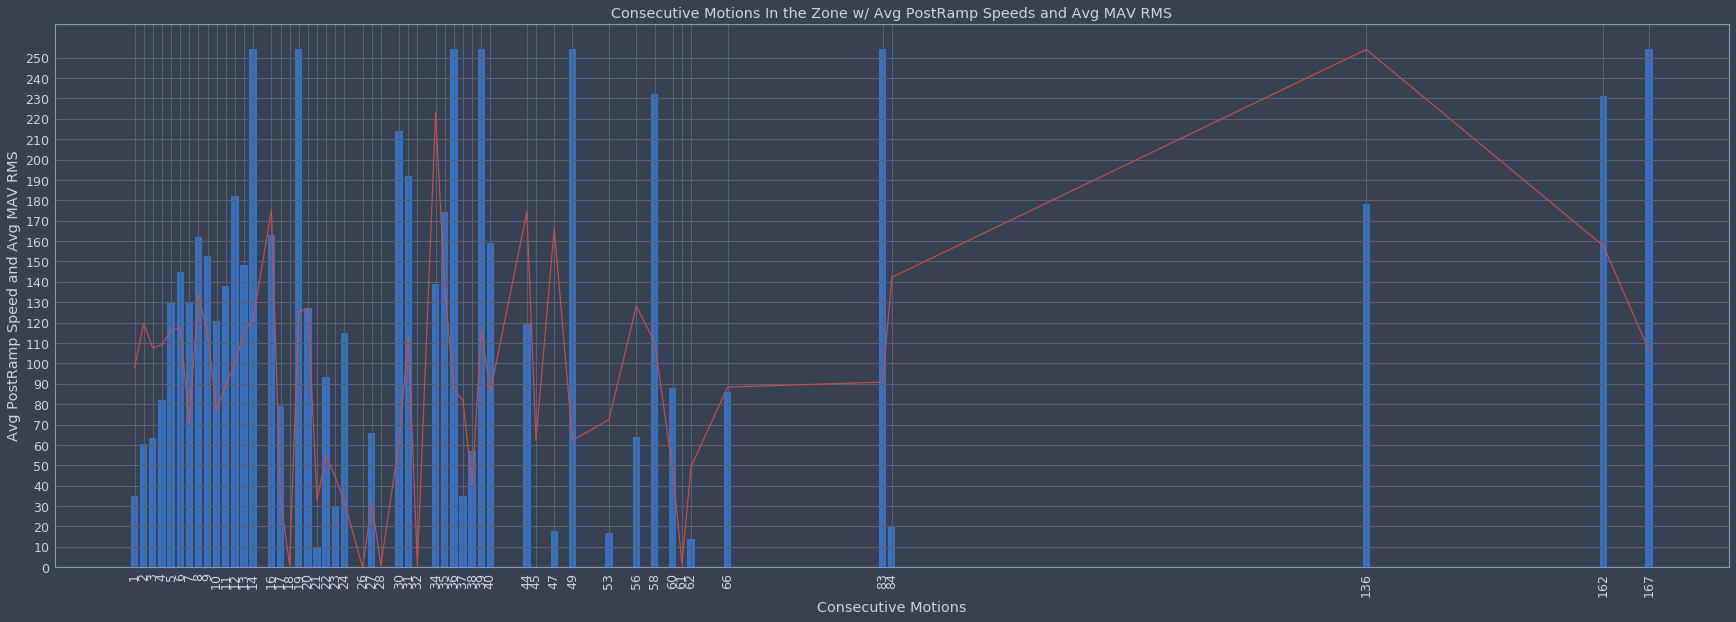

In [4]:
# using data from one user
data = InTheZone[0]
consec_avg_speed = consecutive_motions_w_avg_speed(data)
consec_avg_rms = consecutive_motions_w_avg_rms(data)

plt.figure(figsize=(30,10))
plt.bar(consec_avg_speed[:, 0], consec_avg_speed[:, 1], label='Avg Speed')
plt.plot(consec_avg_rms[:, 0], consec_avg_rms[:, 1], color='r', label='Avg MAV RMS')
plt.title("Consecutive Motions In the Zone w/ Avg PostRamp Speeds and Avg MAV RMS")
plt.xlabel("Consecutive Motions")
plt.ylabel("Avg PostRamp Speed and Avg MAV RMS")
plt.xticks(consec_avg_speed[:, 0], rotation=90, horizontalalignment='center')
plt.yticks(range(0, 260, 10))
plt.show()

### Target vs Output Class

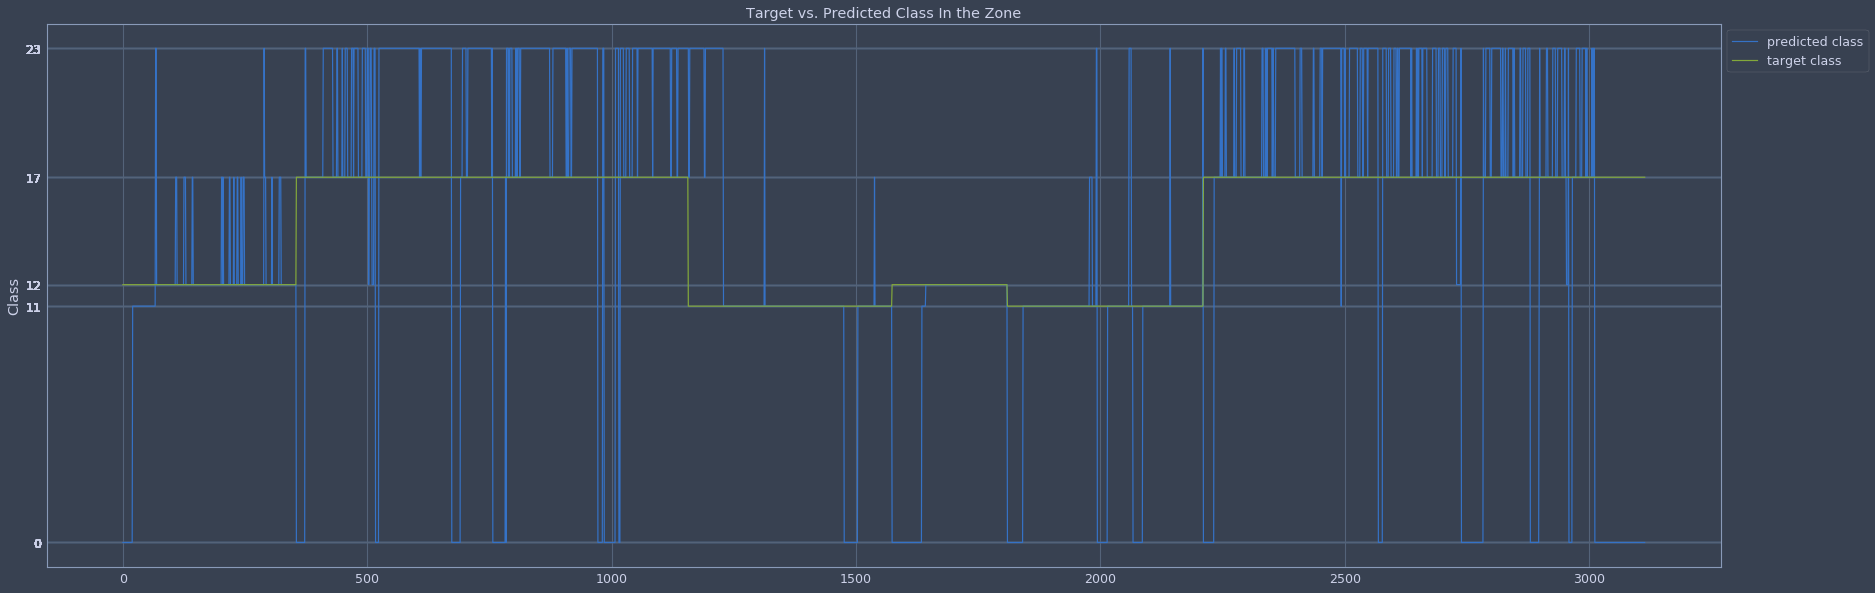

In [17]:
data = InTheZone[0]
predicted_class = data['class'].to_numpy()
target_class = data['targetClass'].to_numpy()

plt.figure(figsize=(30,10))
points = len(target_class)
x = range(points)
plt.plot(x, predicted_class, label='predicted class')
plt.plot(x, target_class, label='target class')
plt.title("Target vs. Predicted Class In the Zone")
plt.ylabel("Class")
plt.yticks(target_class)
plt.yticks(predicted_class)
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.show()

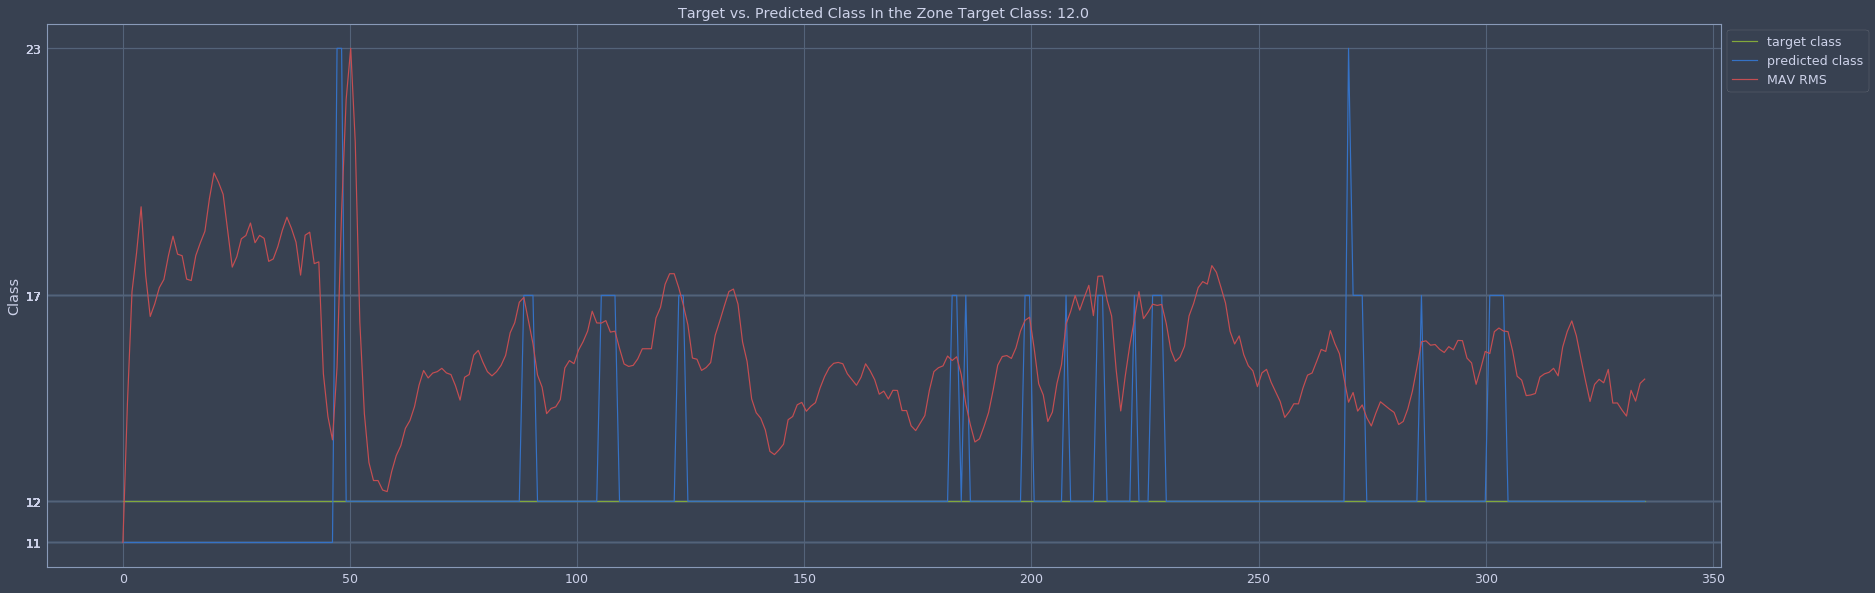

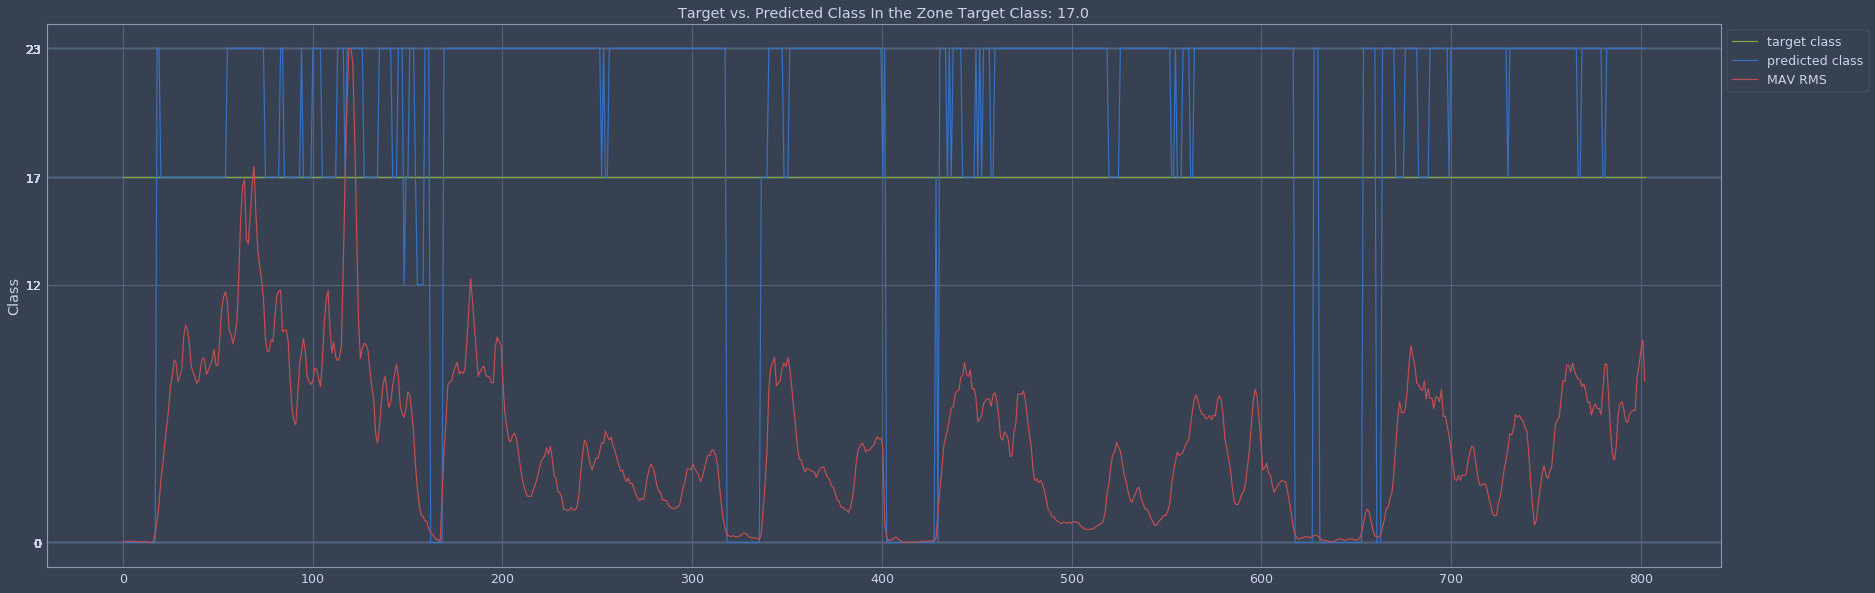

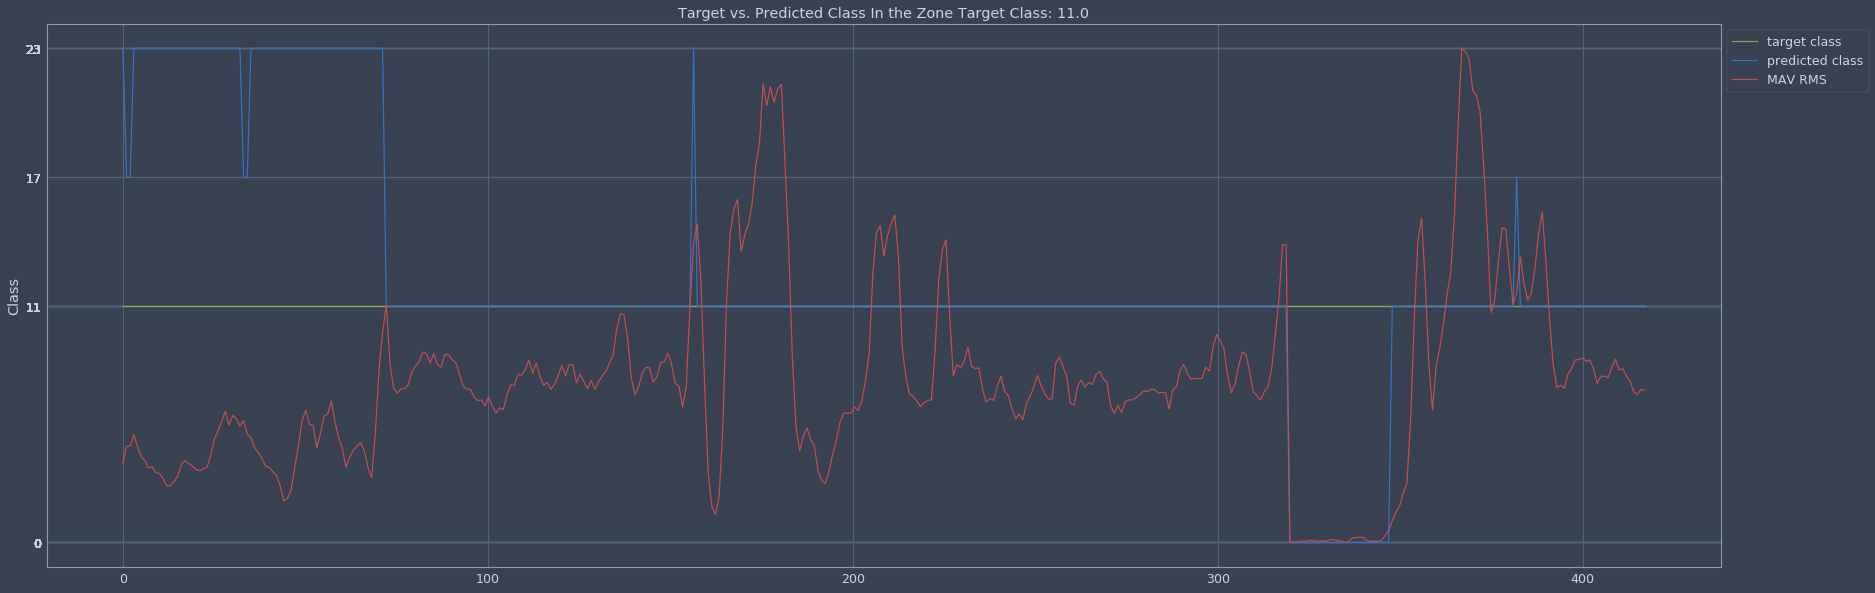

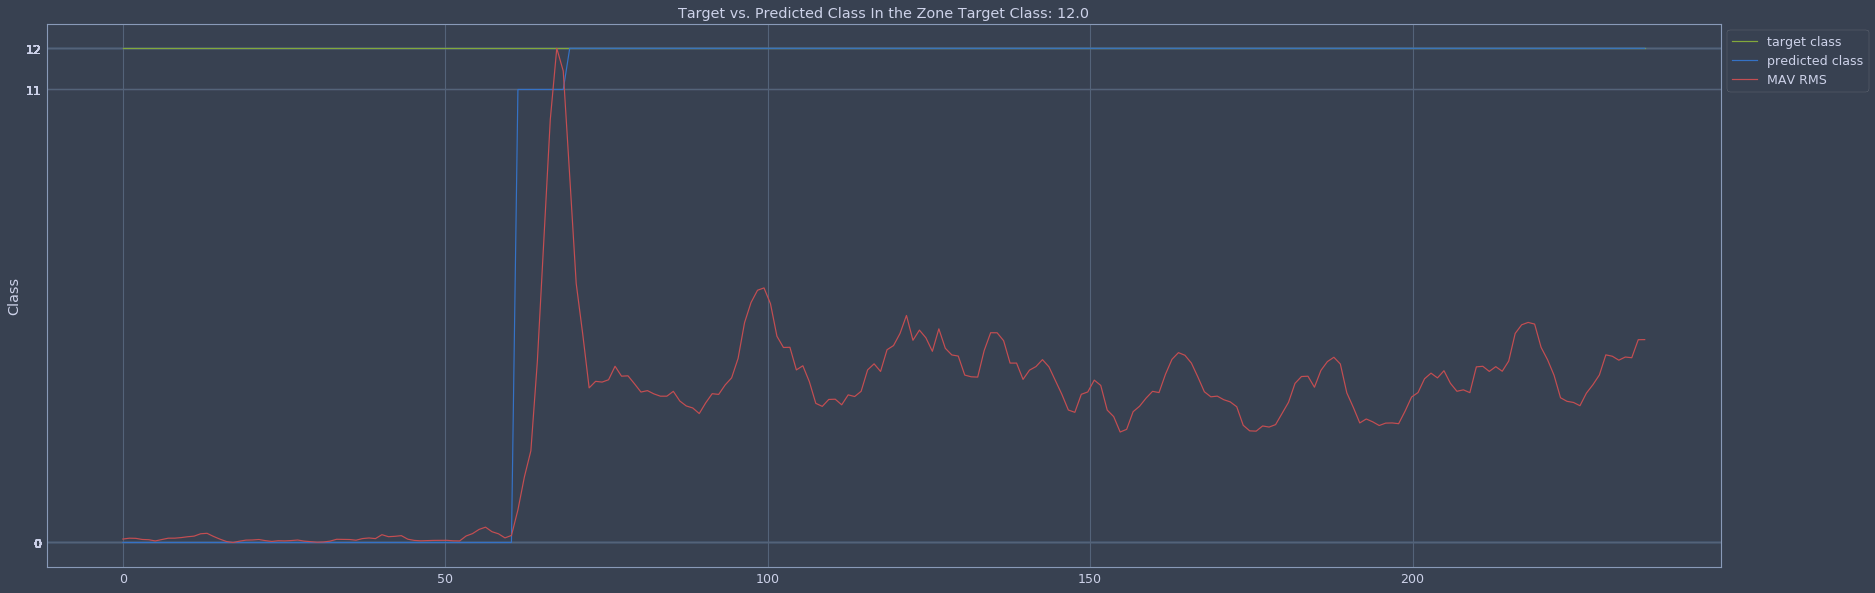

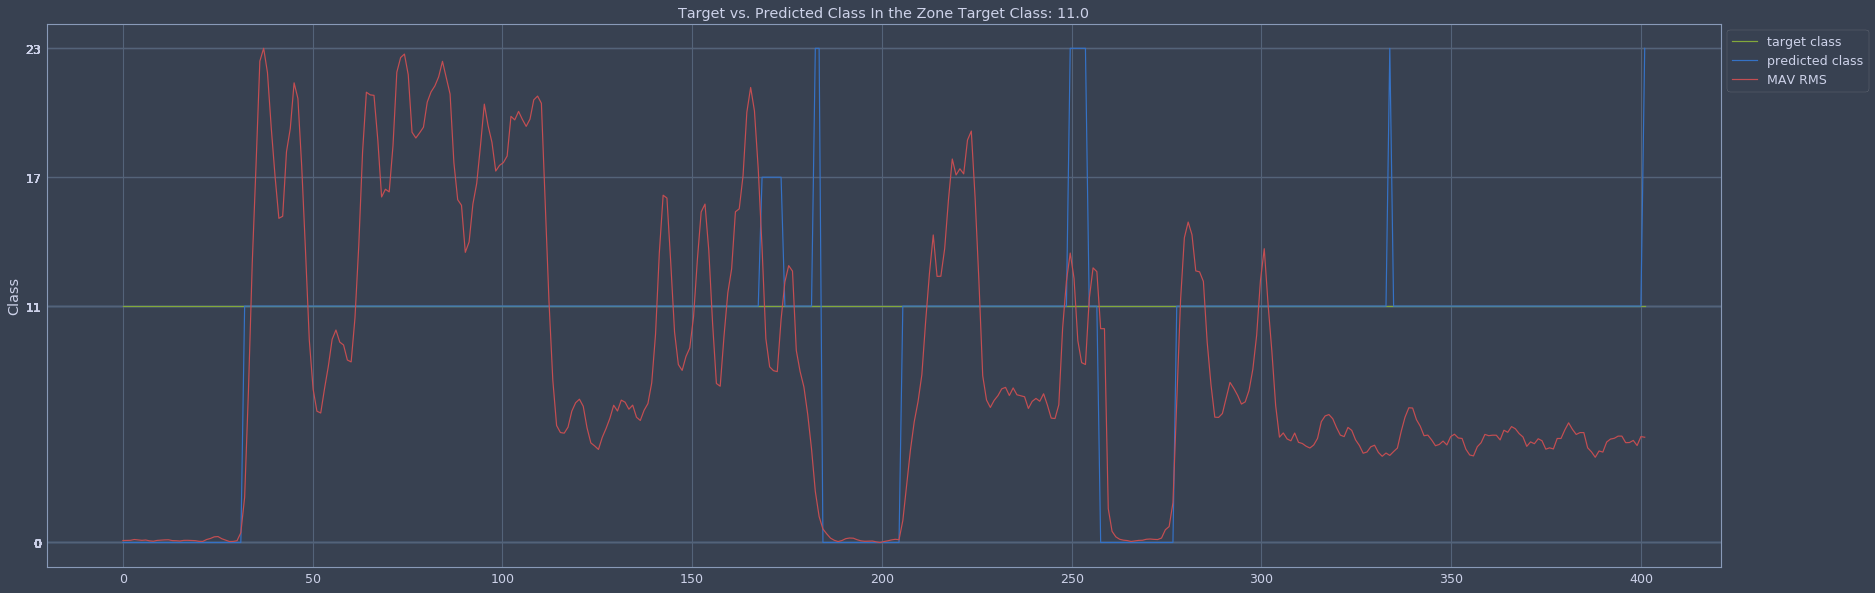

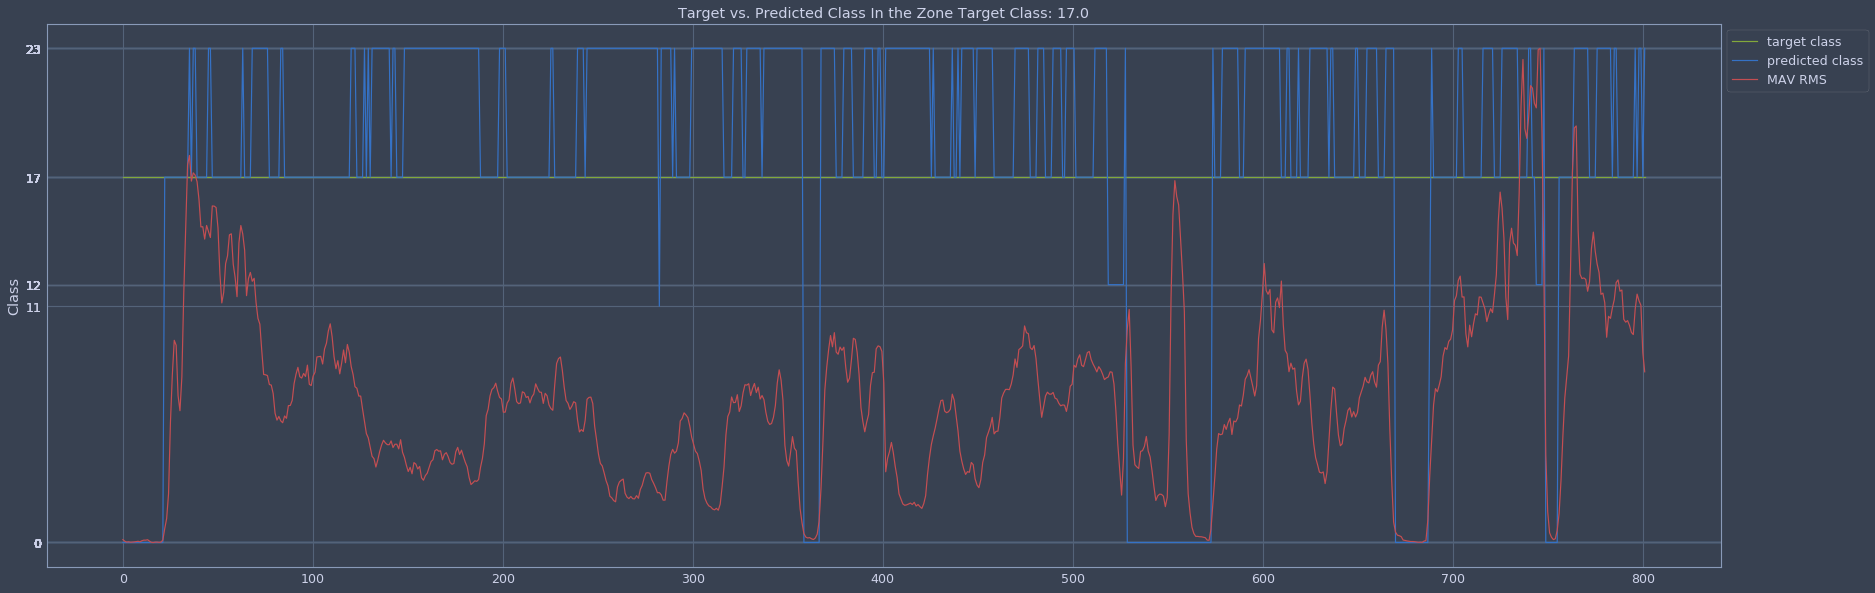

In [6]:
data = InTheZone[0]
values = target_vs_predicted_w_RMS(data)
    
# plot each set of target class with the predicted class
for value in values:
    plt.figure(figsize=(30,10))
    points = len(value)
    x = np.linspace(0, points, points)
    OldRange = (value[:,10].max() - value[:,10].min())
    NewRange = (value[:,0].max() - value[:,0].min())
    value[:,10] = (((value[:,10] - value[:,10].min()) * NewRange) / OldRange) + value[:,0].min()
    plt.plot(x, value[:,1], label='target class', color='g')
    plt.plot(x, value[:,0], label='predicted class', color='b')
    plt.plot(x, value[:,10], label='MAV RMS', color='r')
    plt.title(f"Target vs. Predicted Class In the Zone Target Class: {value[0,1]}")
    plt.ylabel("Class")
    plt.yticks(value[:,1])
    plt.yticks(value[:,0])
    plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
    plt.show()

[Correct, Incorrect, Motion(1)/No Motion(0)] 
[[39, 3, 1], [14, 4, 1], [13, 2, 1], [58, 2, 1], [1, 1, 1], [12, 2, 1], [7, 1, 1], [6, 2, 1], [6, 1, 1], [3, 3, 1], [40, 1, 1], [12, 1, 1], [14, 4, 1]]


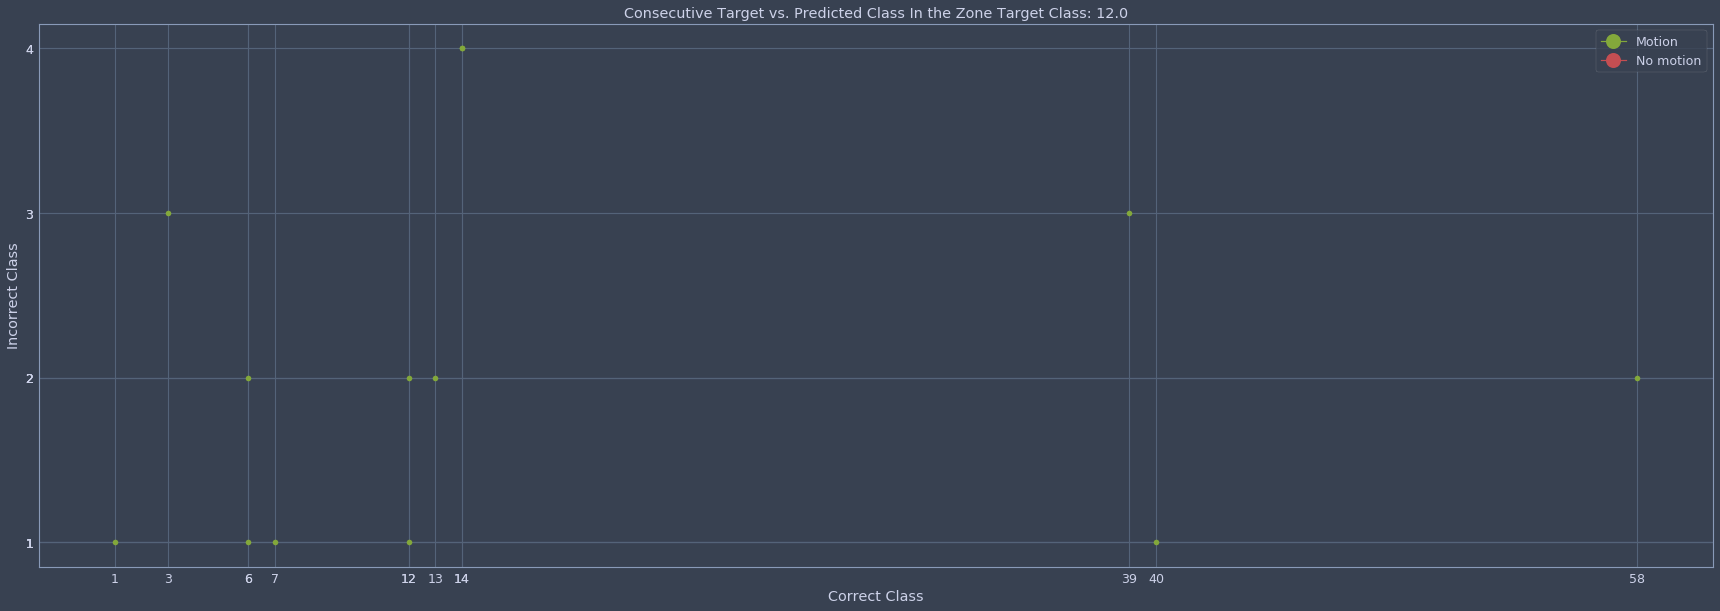

[Correct, Incorrect, Motion(1)/No Motion(0)] 
[[35, 20, 1], [8, 2, 1], [9, 1, 1], [5, 5, 1], [8, 4, 1], [1, 9, 1], [8, 7, 1], [3, 3, 1], [2, 3, 1], [1, 4, 1], [1, 1, 1], [2, 62, 1], [4, 8, 1], [3, 49, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 5, 1], [7, 1, 1], [1, 1, 1], [1, 4, 1], [2, 60, 1], [6, 27, 1], [2, 1, 1], [3, 4, 1], [2, 53, 1], [5, 7, 1], [6, 10, 1], [1, 30, 1], [1, 36, 1], [2, 11, 1], [2, 21, 1]]


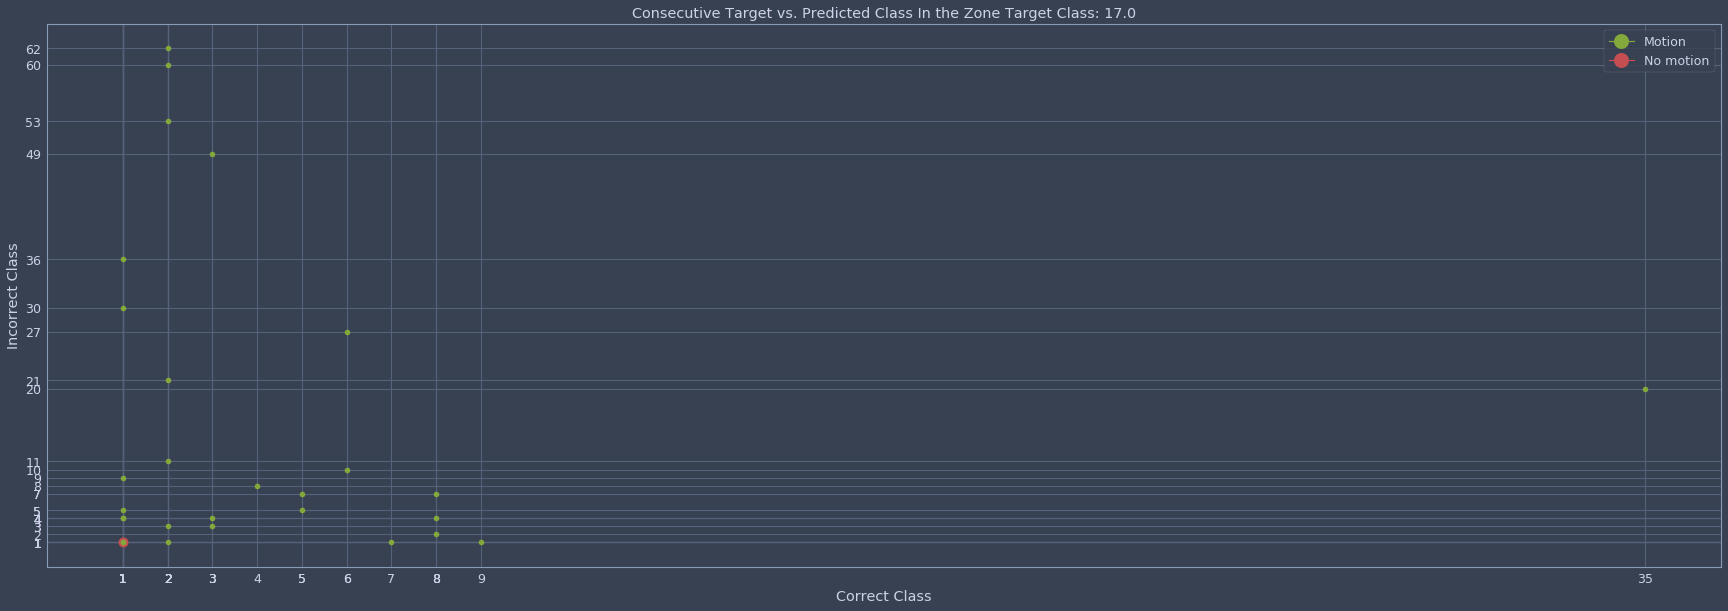

[Correct, Incorrect, Motion(1)/No Motion(0)] 
[[84, 1, 1], [162, 28, 0], [34, 1, 1]]


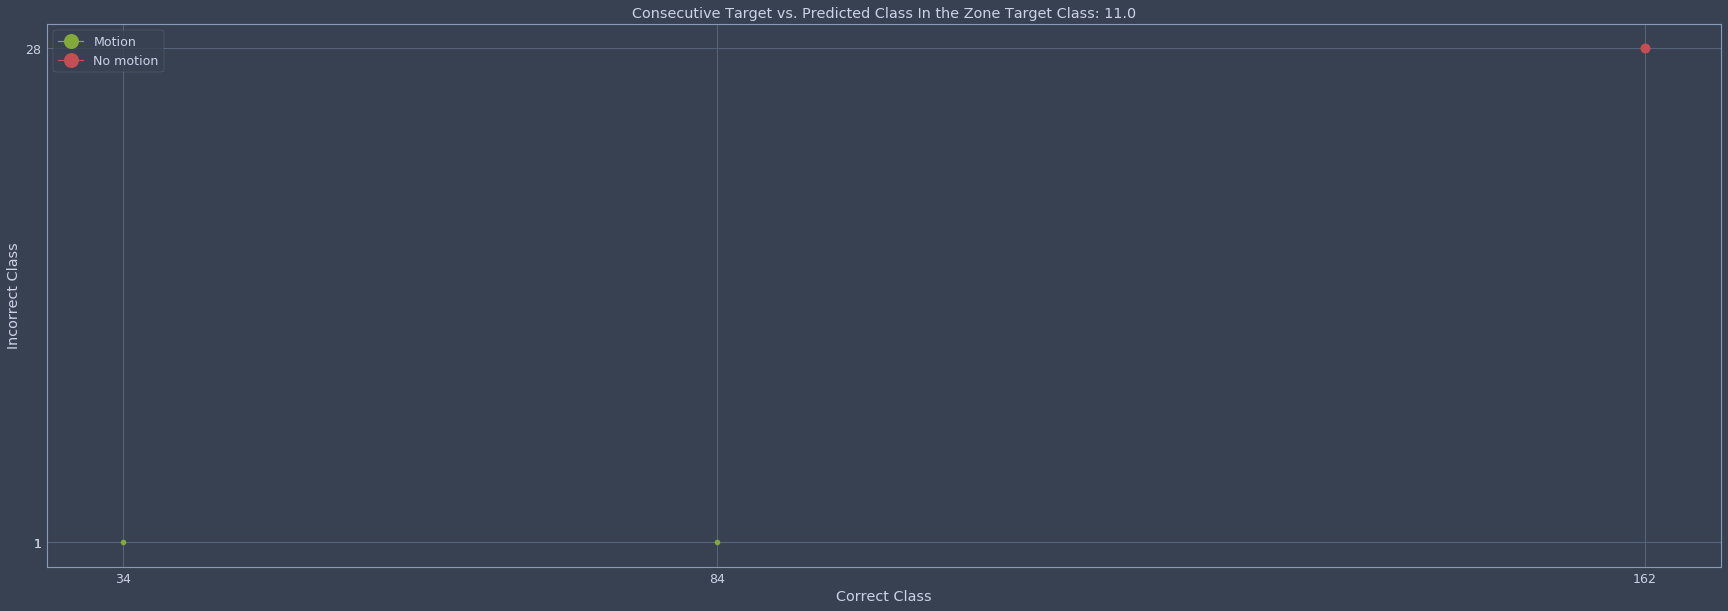

[Correct, Incorrect, Motion(1)/No Motion(0)] 
[[136, 6, 1], [8, 2, 1], [44, 5, 1], [3, 20, 0], [56, 1, 1], [66, 1, 1]]


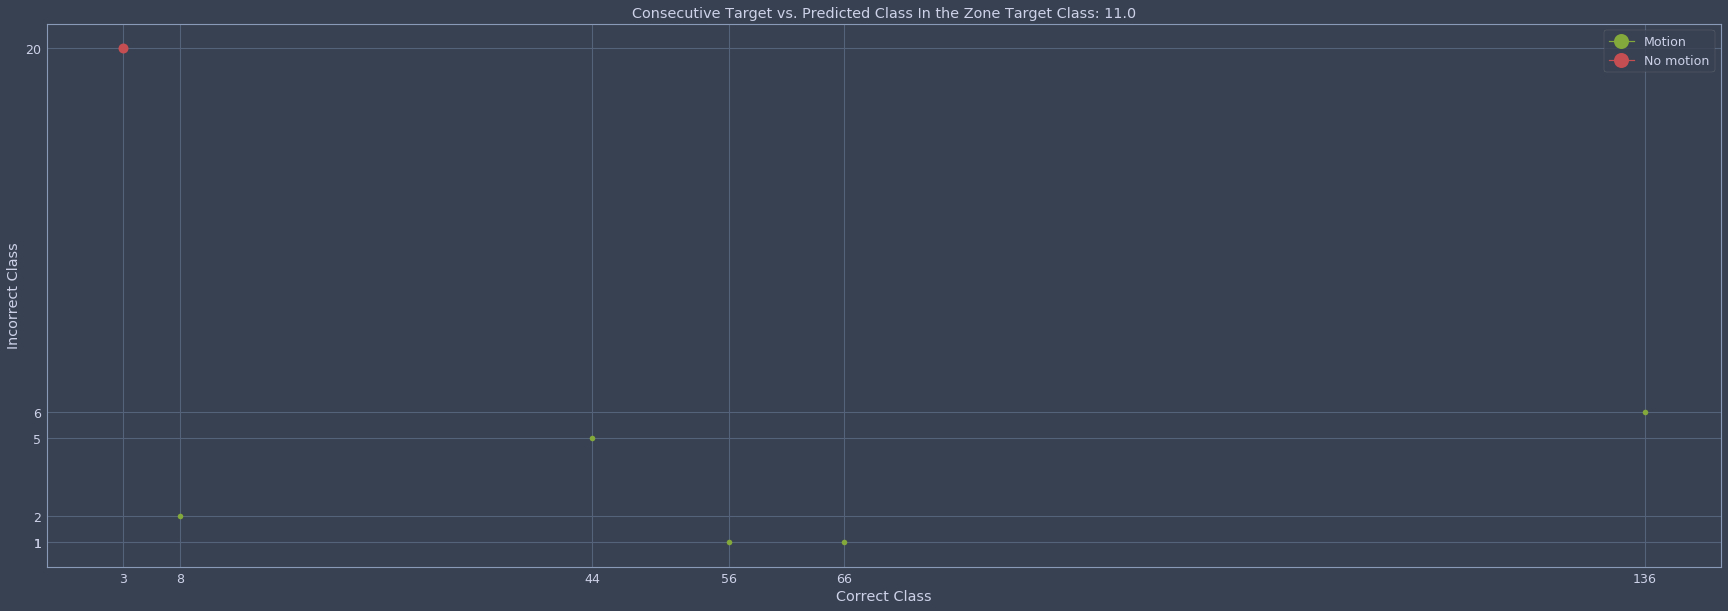

[Correct, Incorrect, Motion(1)/No Motion(0)] 
[[13, 1, 1], [1, 2, 1], [6, 2, 1], [16, 1, 1], [4, 9, 1], [6, 2, 1], [35, 3, 1], [4, 1, 1], [1, 1, 1], [1, 10, 1], [1, 2, 1], [4, 40, 1], [10, 4, 1], [23, 2, 1], [12, 4, 1], [1, 38, 1], [1, 1, 1], [8, 17, 1], [5, 5, 1], [2, 8, 1], [1, 21, 1], [4, 5, 1], [6, 5, 1], [2, 2, 1], [2, 24, 1], [1, 1, 1], [9, 1, 1], [2, 1, 1], [1, 7, 1], [1, 9, 1], [11, 8, 1], [4, 4, 1], [4, 5, 1], [2, 5, 1], [10, 7, 1], [4, 9, 1], [3, 19, 1], [3, 2, 1], [4, 1, 1], [5, 10, 1], [1, 2, 1], [11, 2, 1], [4, 6, 1], [4, 5, 1], [13, 3, 1], [10, 6, 1], [4, 9, 1], [5, 2, 1], [2, 4, 1], [8, 8, 1], [4, 8, 1], [1, 2, 1], [9, 1, 1], [1, 2, 1], [1, 1, 1]]


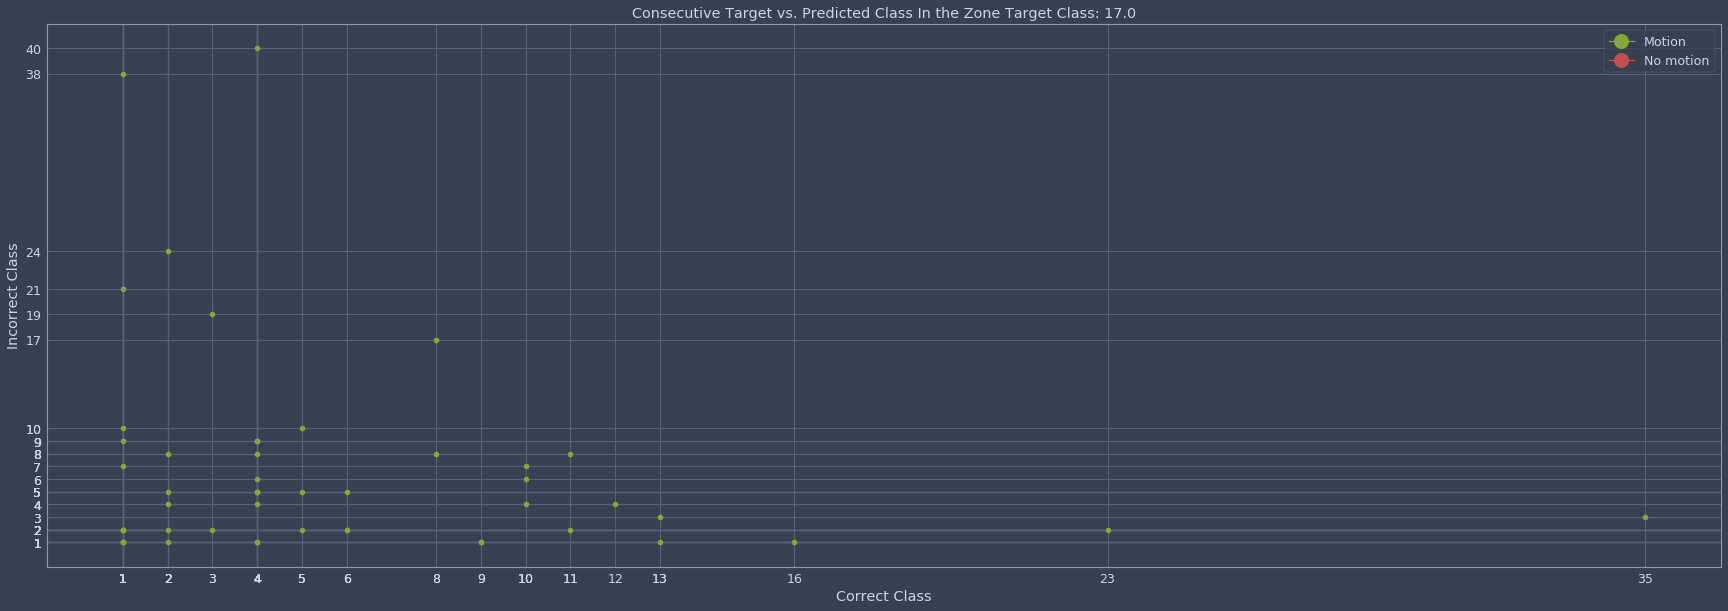

In [15]:
data = InTheZone[0]
consecutive_target_vs_predicted_ITZ(data)

## Simon Says

### Consecutive Motions

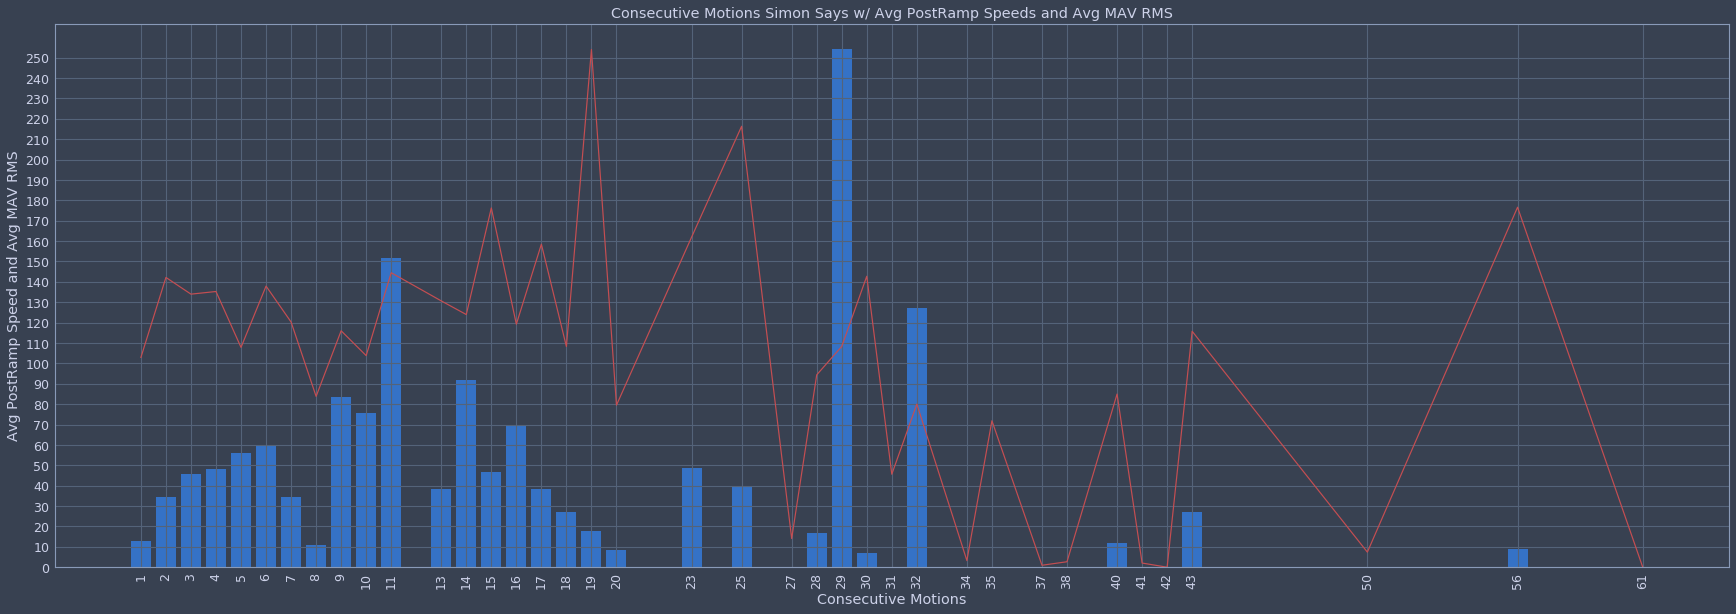

In [13]:
# using data from one user
data = SimonSays[0]
consec_avg_speed = consecutive_motions_w_avg_speed(data)
consec_avg_rms = consecutive_motions_w_avg_rms(data)
    
plt.figure(figsize=(30,10))
plt.bar(consec_avg_speed[:, 0], consec_avg_speed[:, 1])
plt.plot(consec_avg_rms[:, 0], consec_avg_rms[:, 1], color='r', label='Avg MAV RMS')
plt.title("Consecutive Motions Simon Says w/ Avg PostRamp Speeds and Avg MAV RMS")
plt.xlabel("Consecutive Motions")
plt.ylabel("Avg PostRamp Speed and Avg MAV RMS")
plt.xticks(consec_avg_speed[:, 0], rotation=90, horizontalalignment='center')
plt.yticks(range(0, 260, 10))
plt.show()

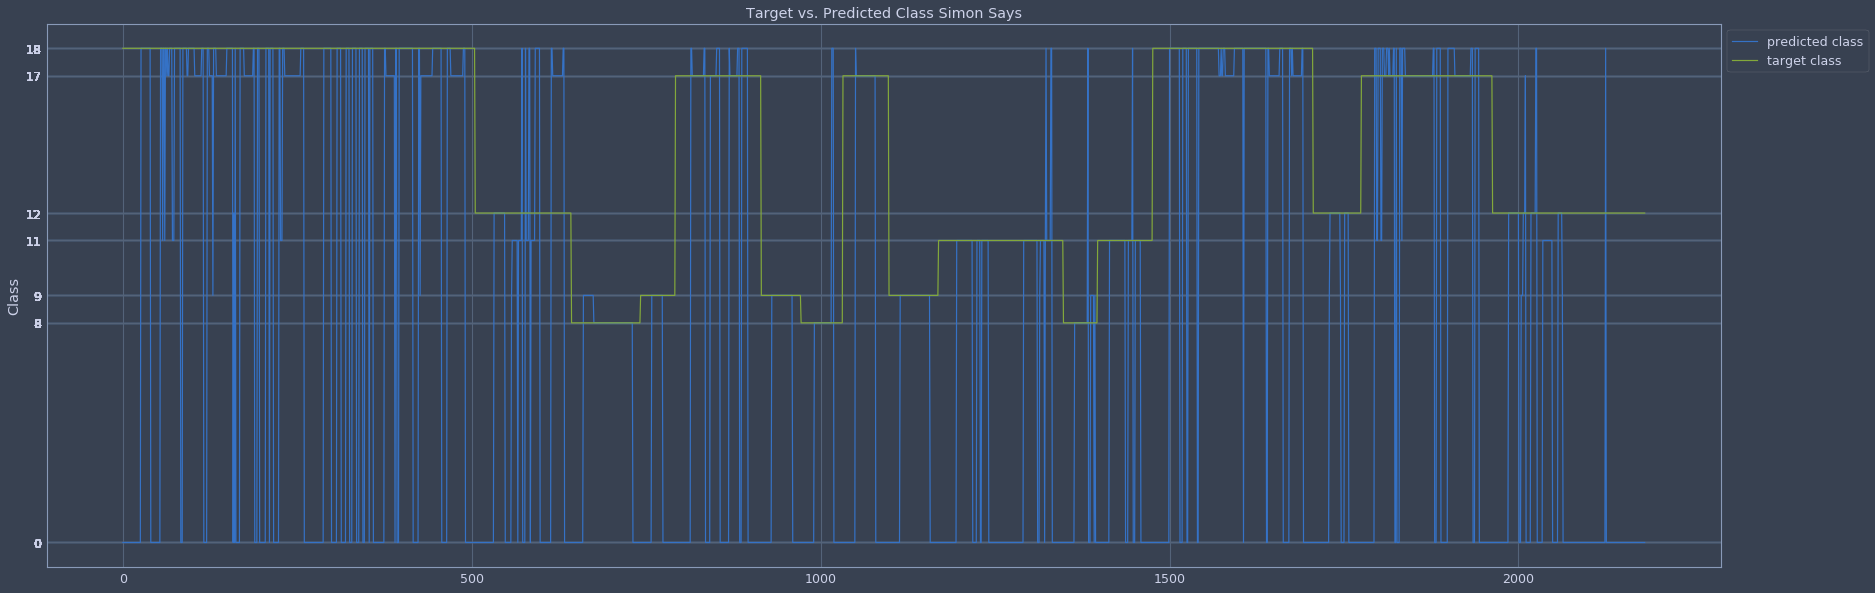

In [16]:
data = SimonSays[0]
predicted_class = data['class'].to_numpy()
target_class = data['targetClass'].to_numpy()

plt.figure(figsize=(30,10))
points = len(target_class)
x = range(points)
plt.plot(x, predicted_class, label='predicted class')
plt.plot(x, target_class, label='target class')
plt.title("Target vs. Predicted Class Simon Says")
plt.ylabel("Class")
plt.yticks(target_class)
plt.yticks(predicted_class)
plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
plt.show()

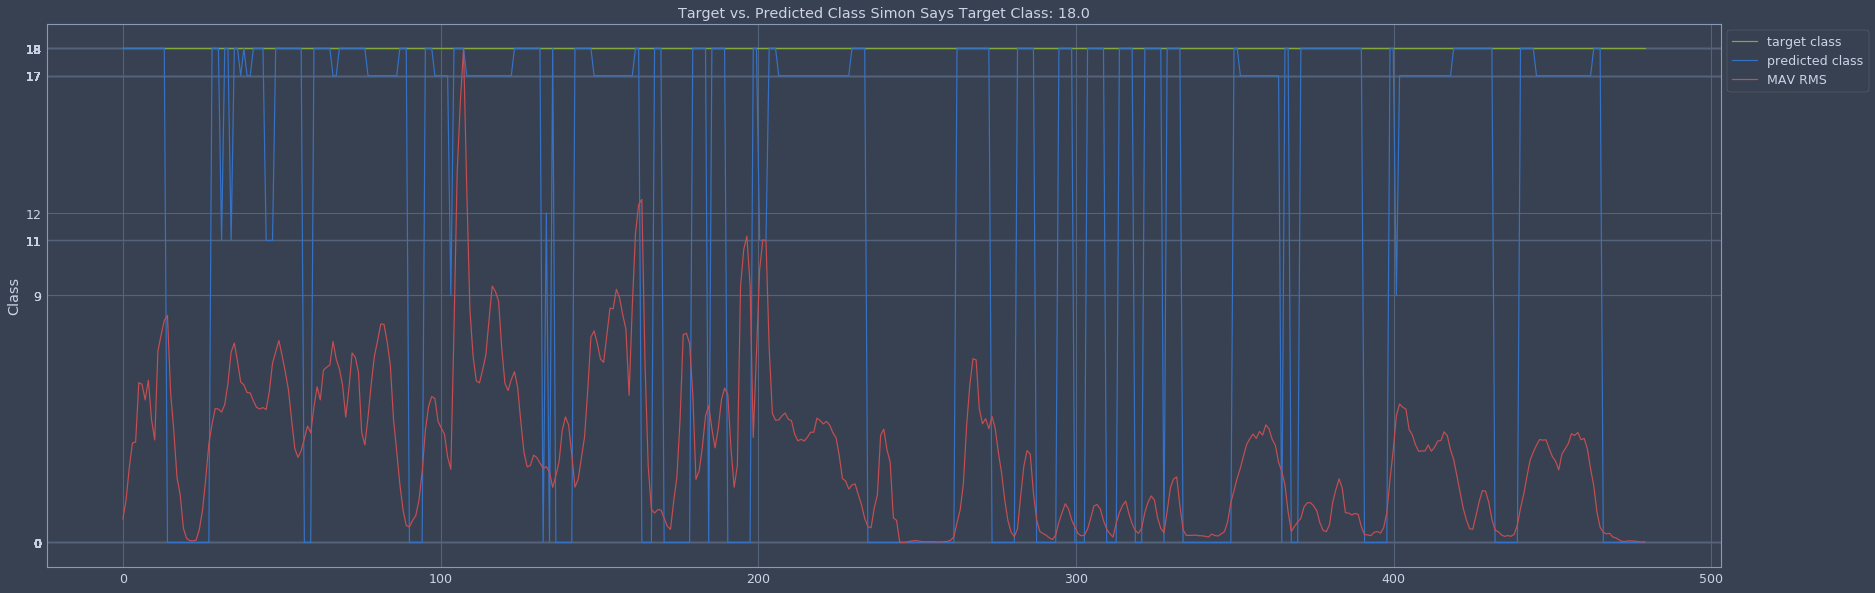

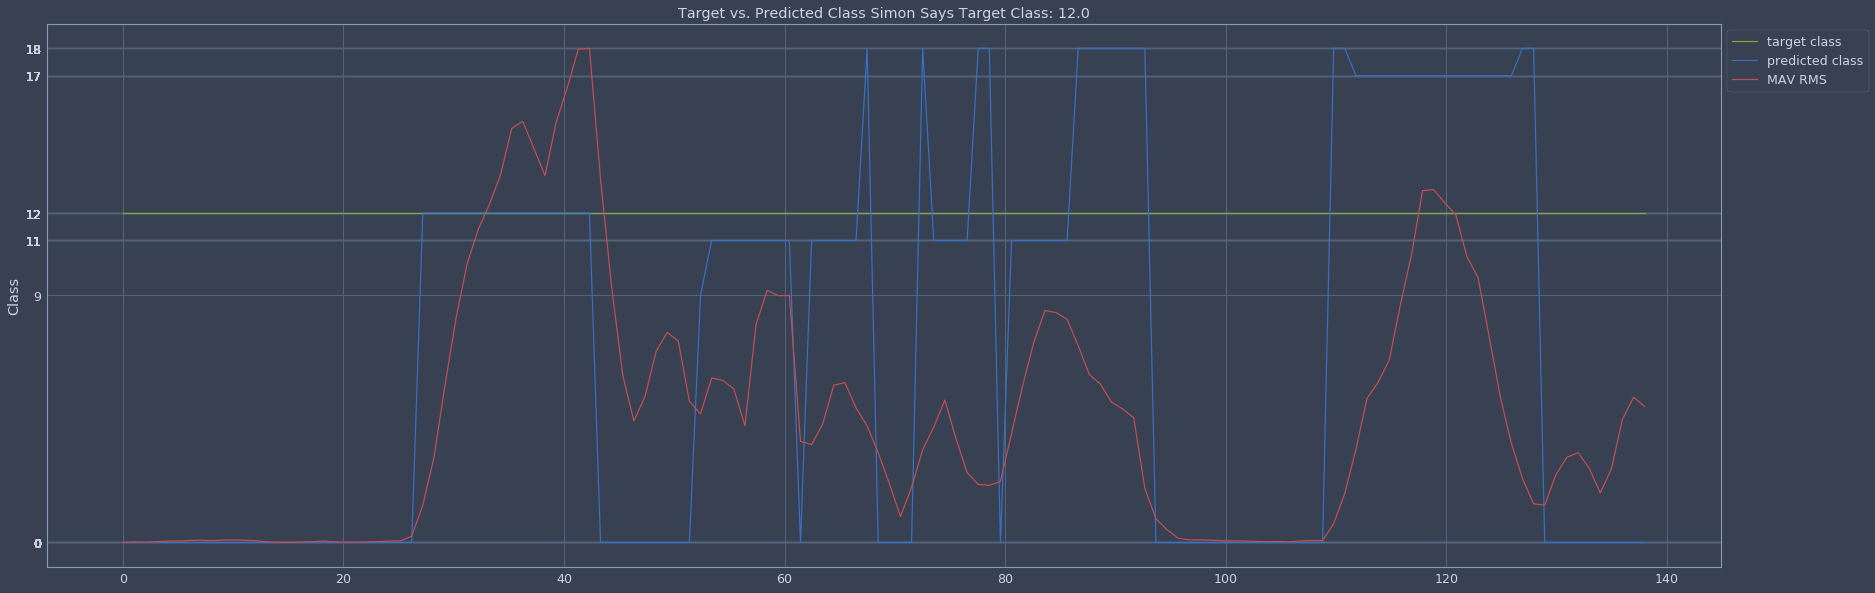

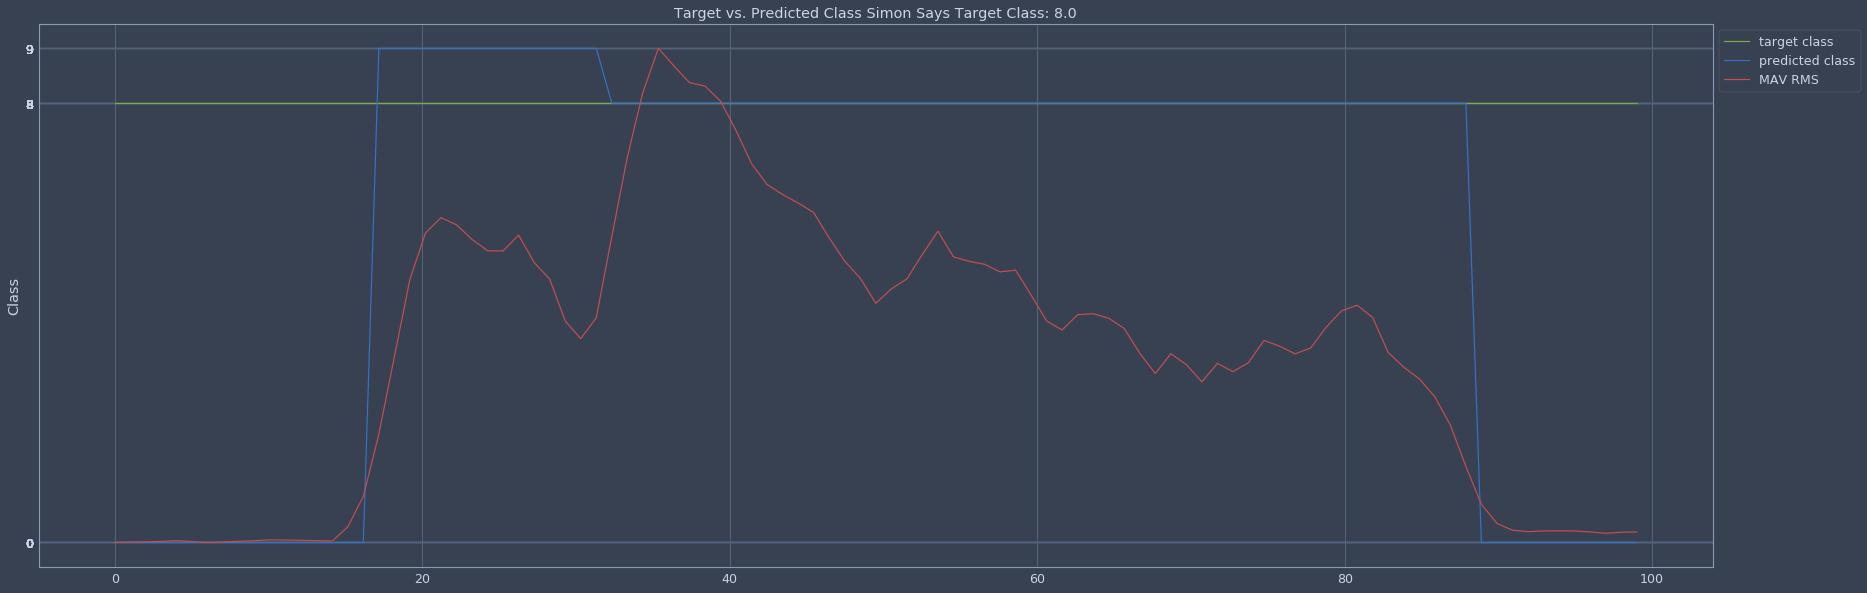

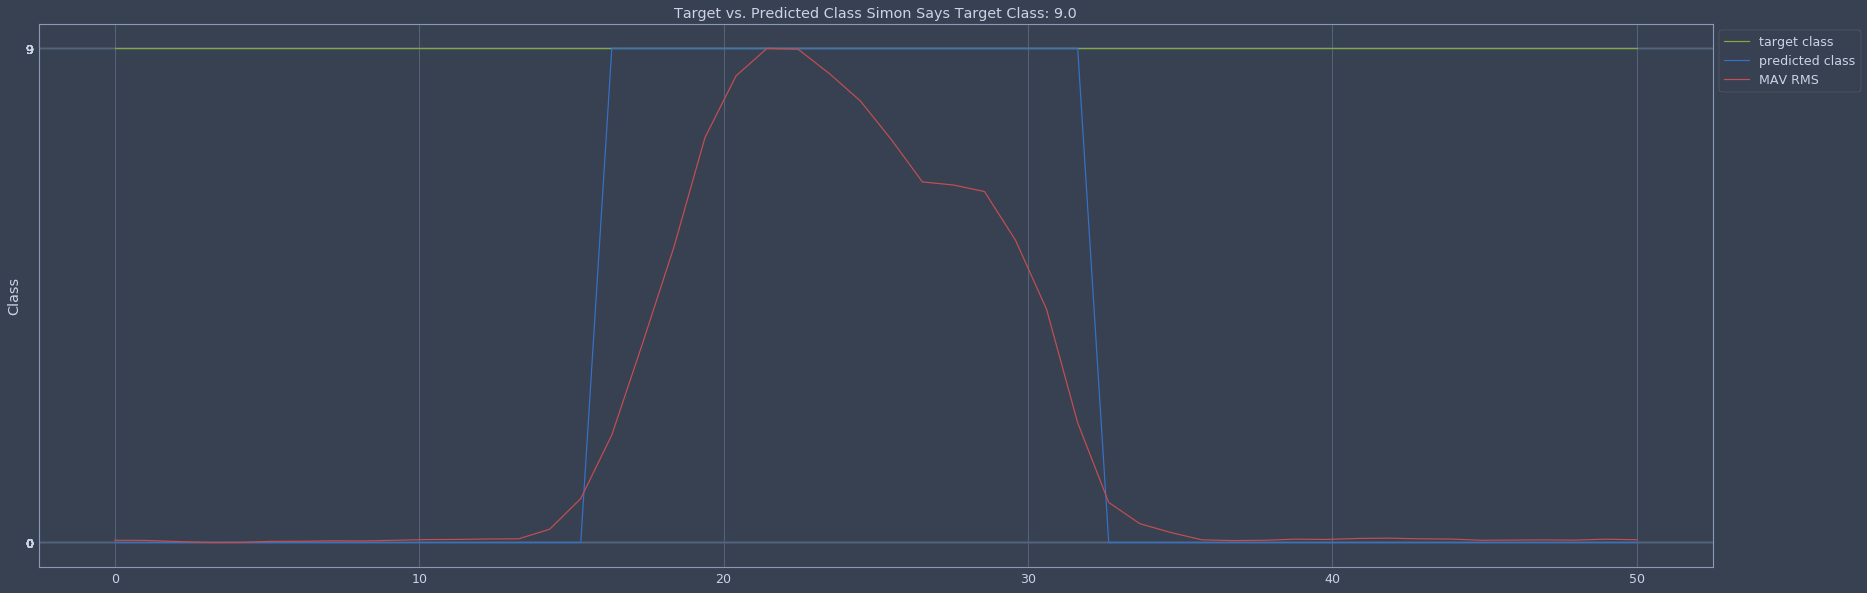

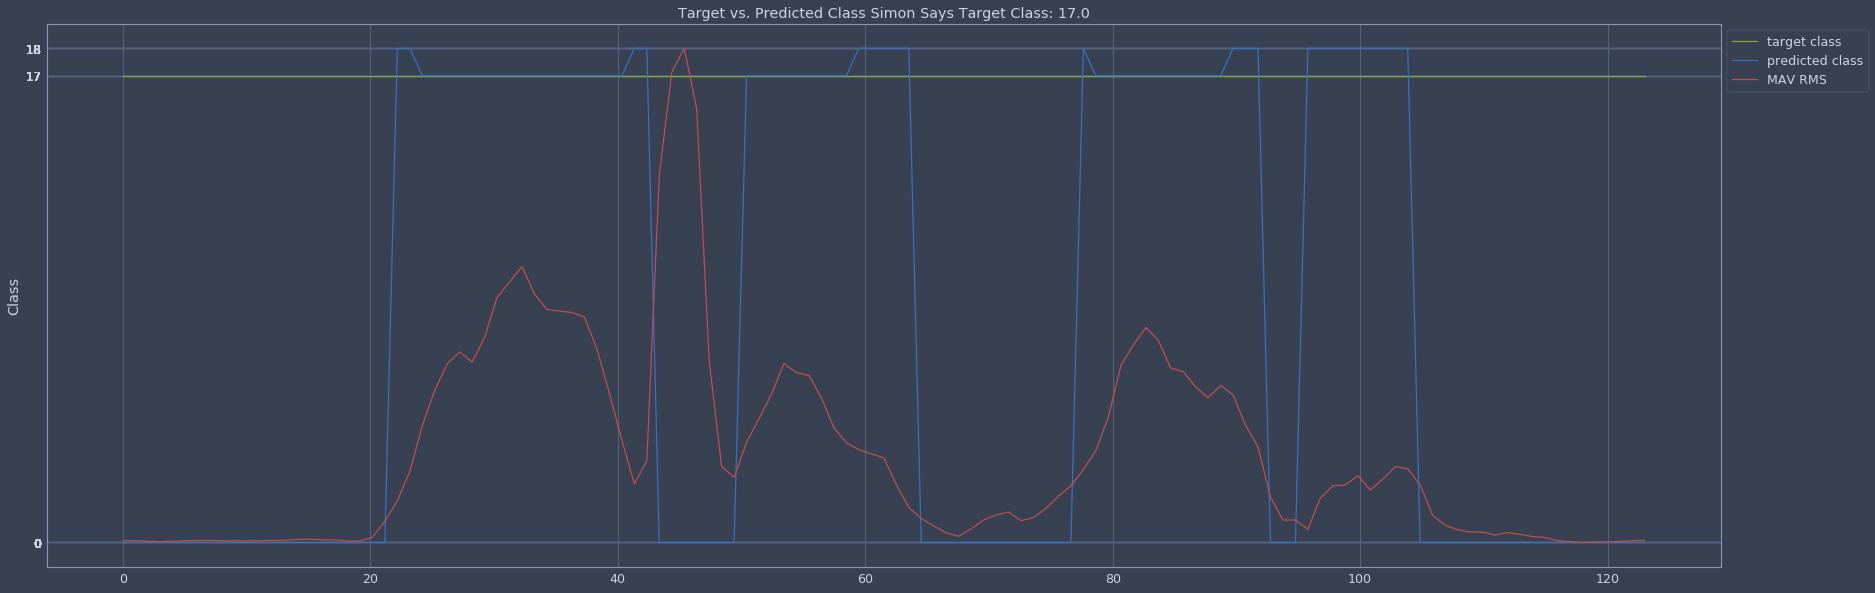

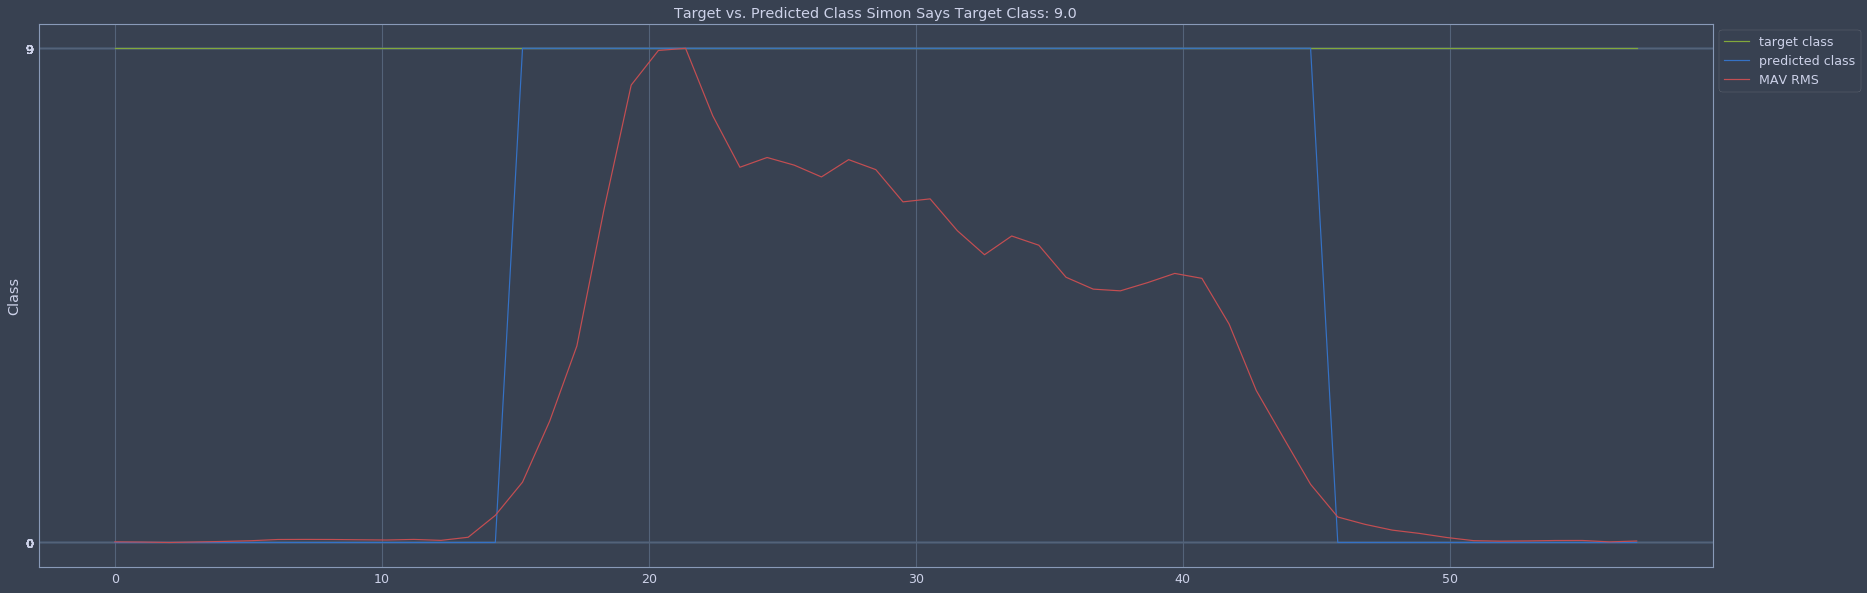

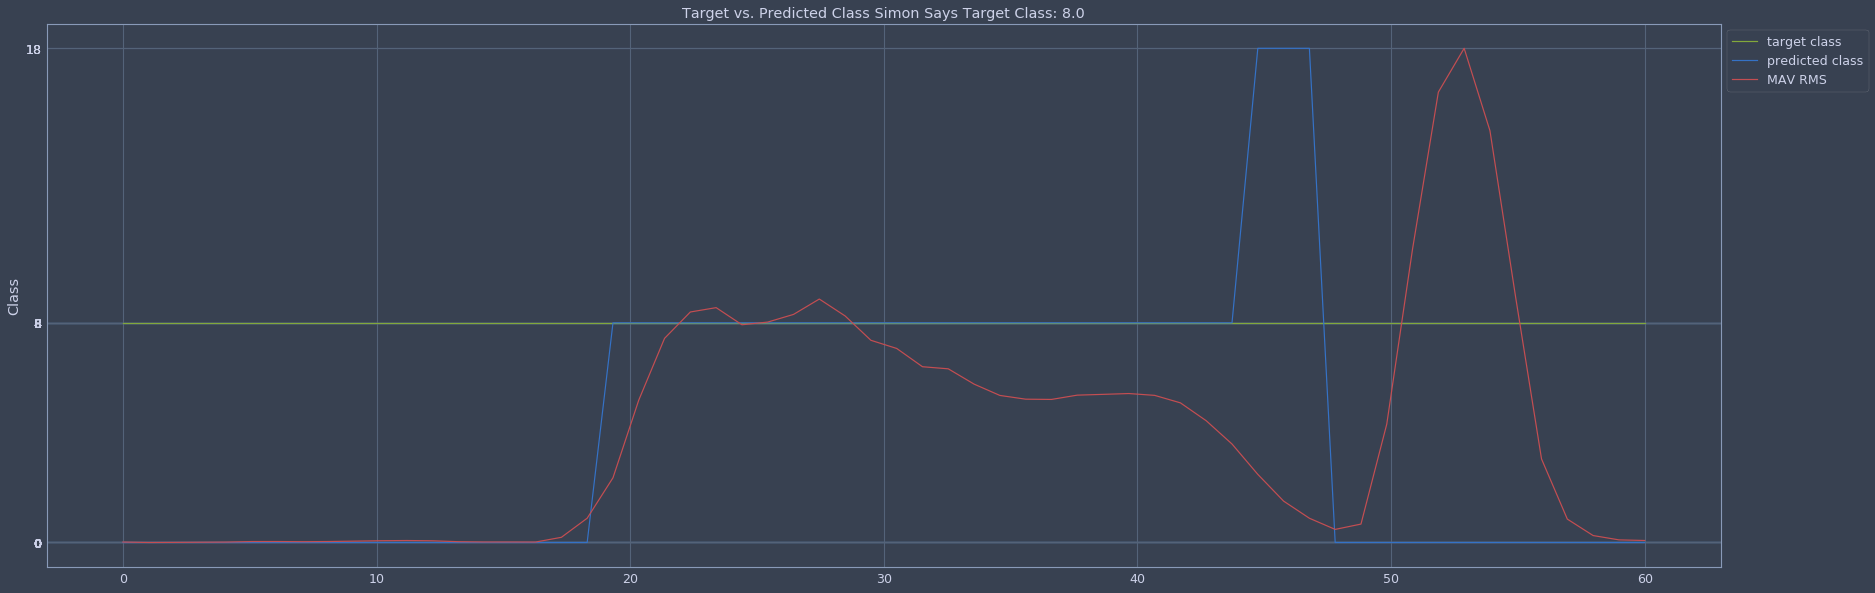

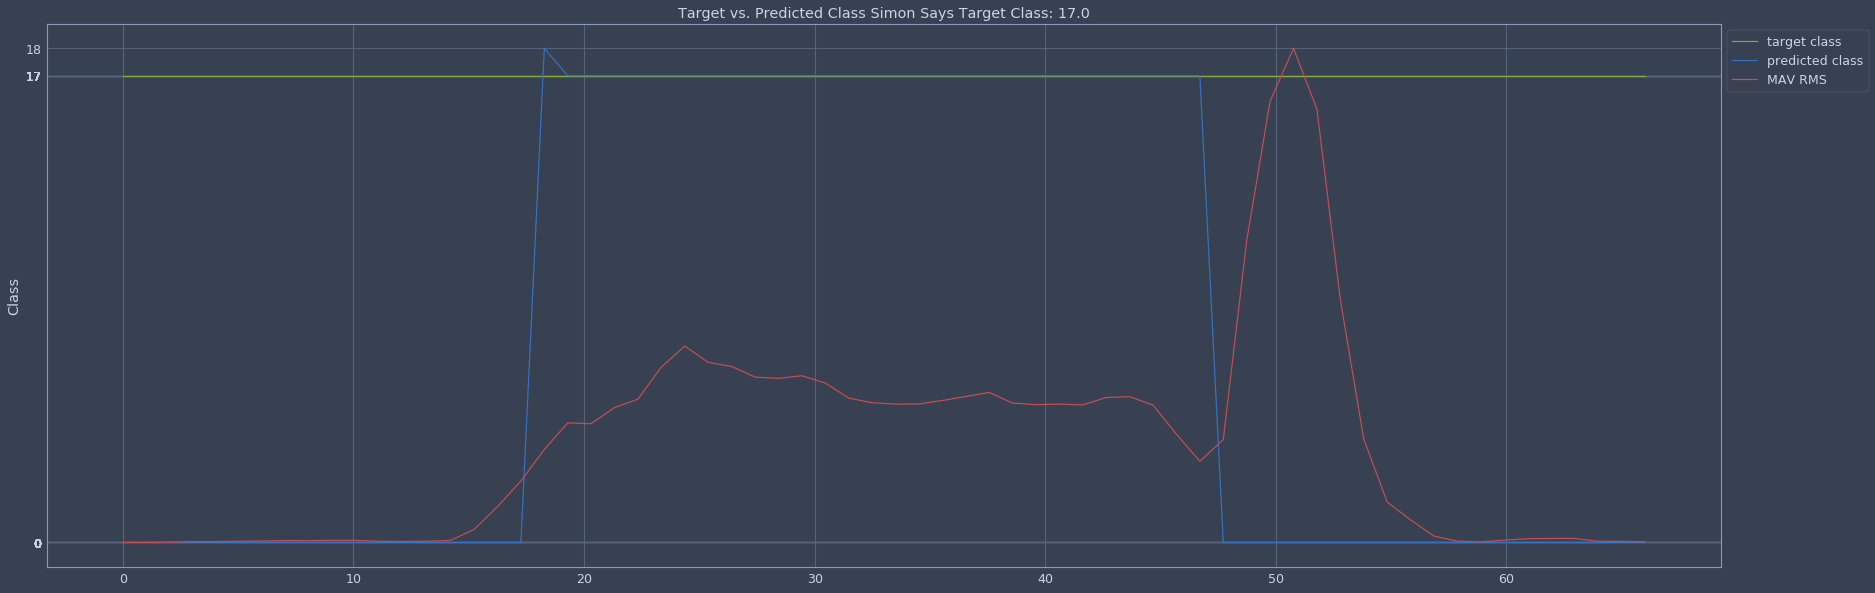

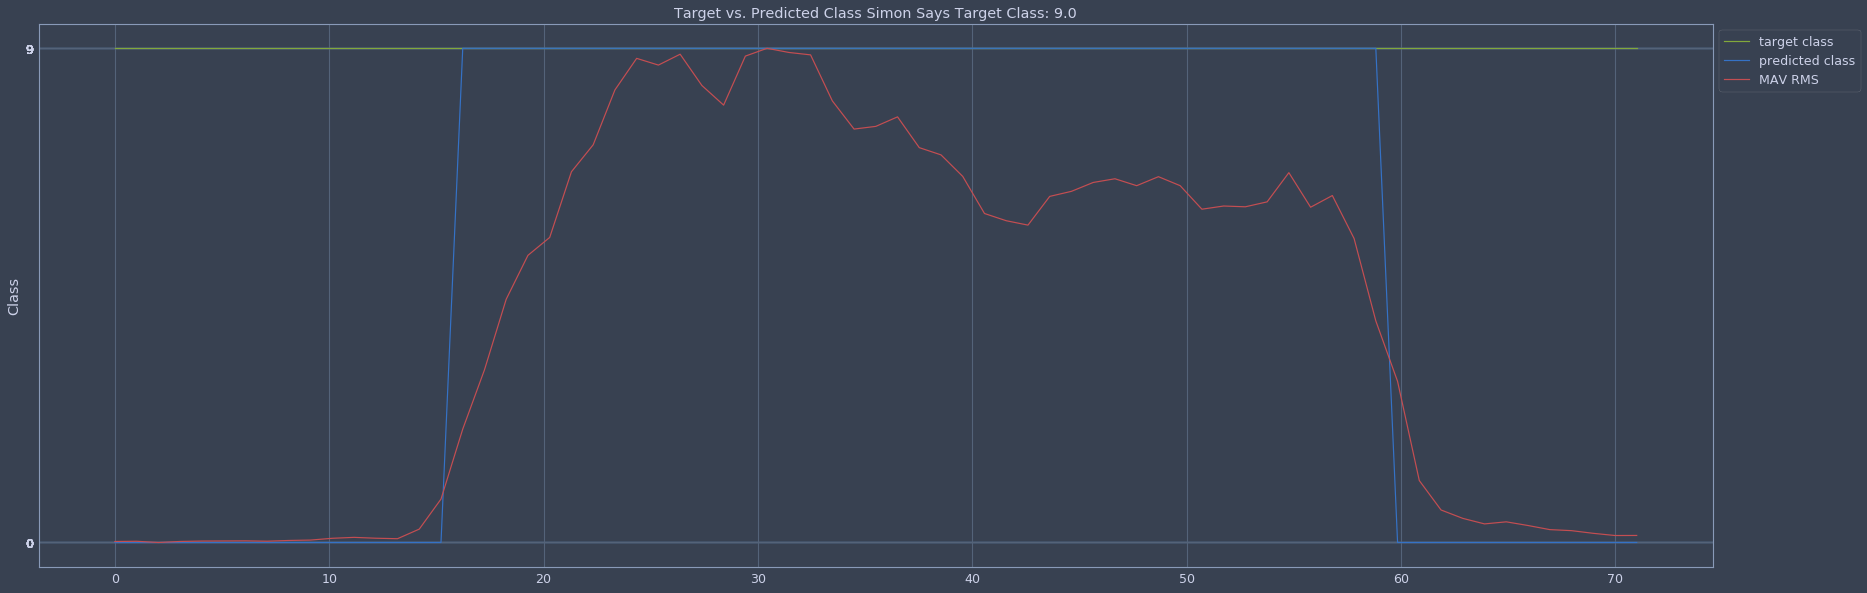

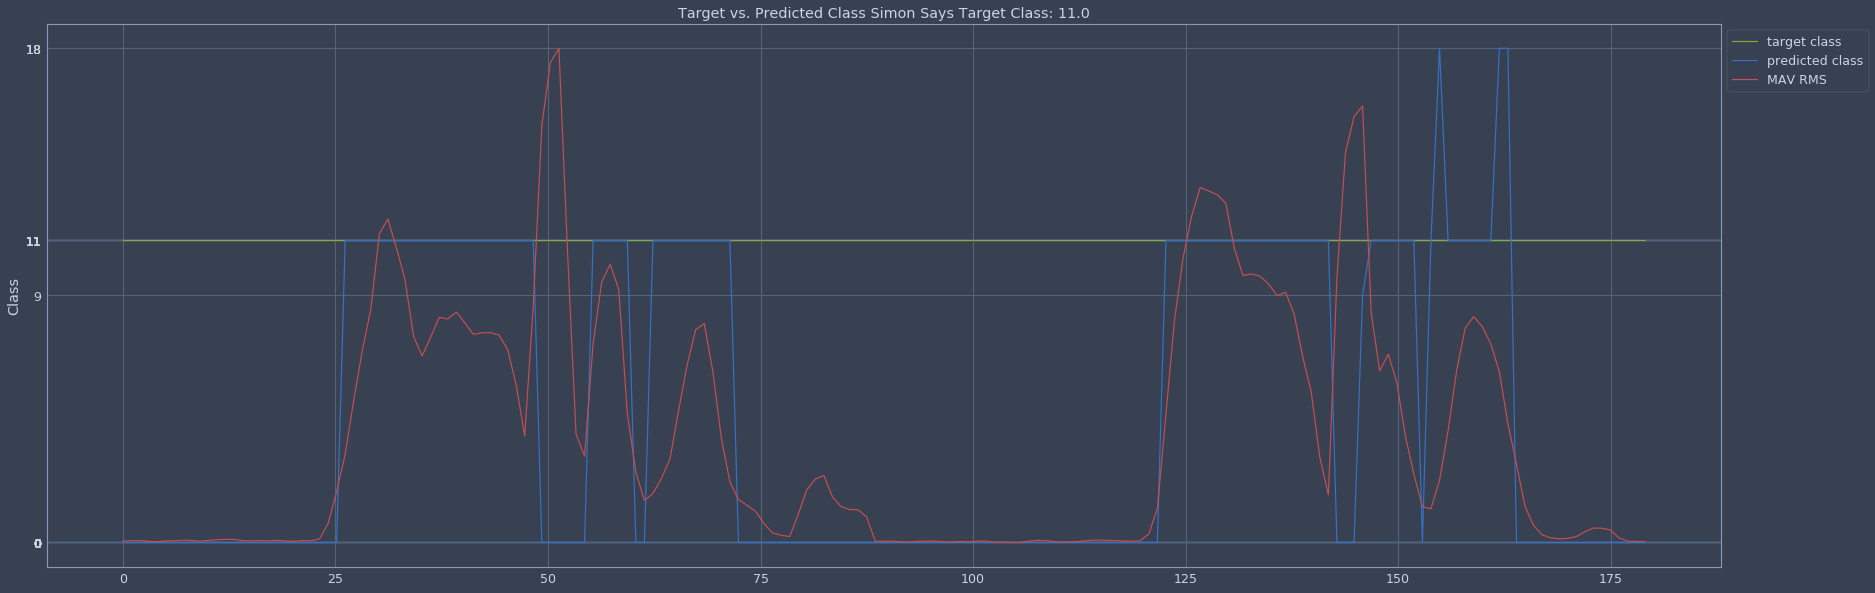

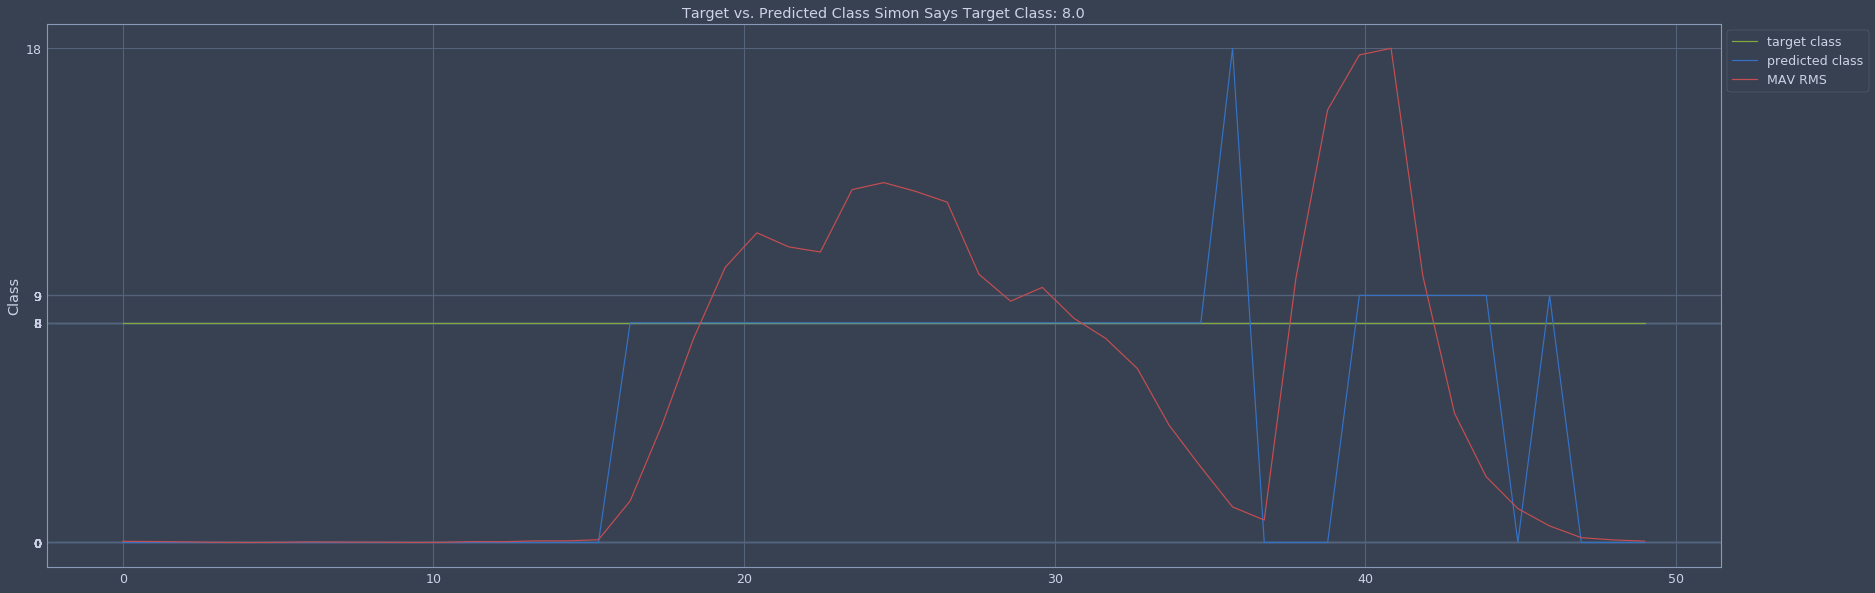

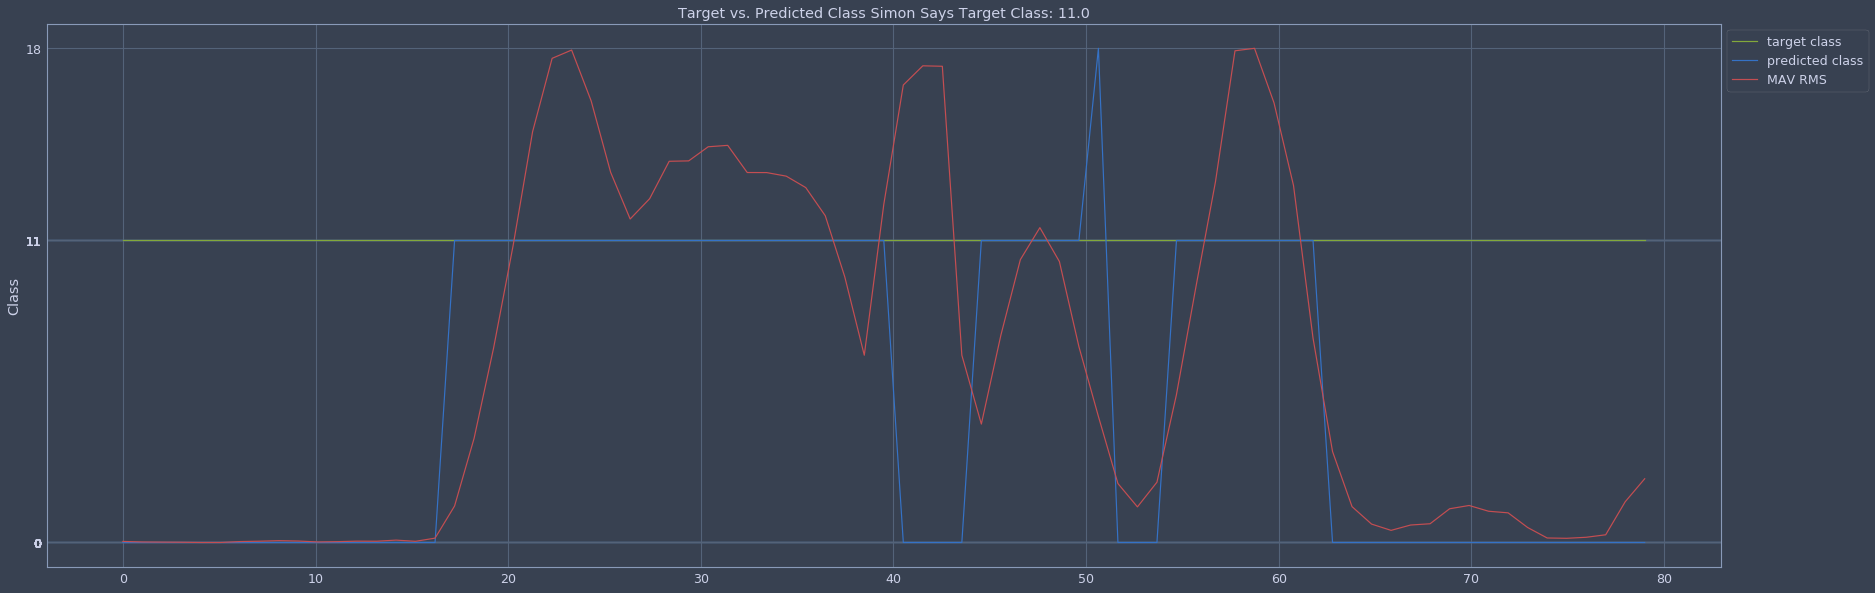

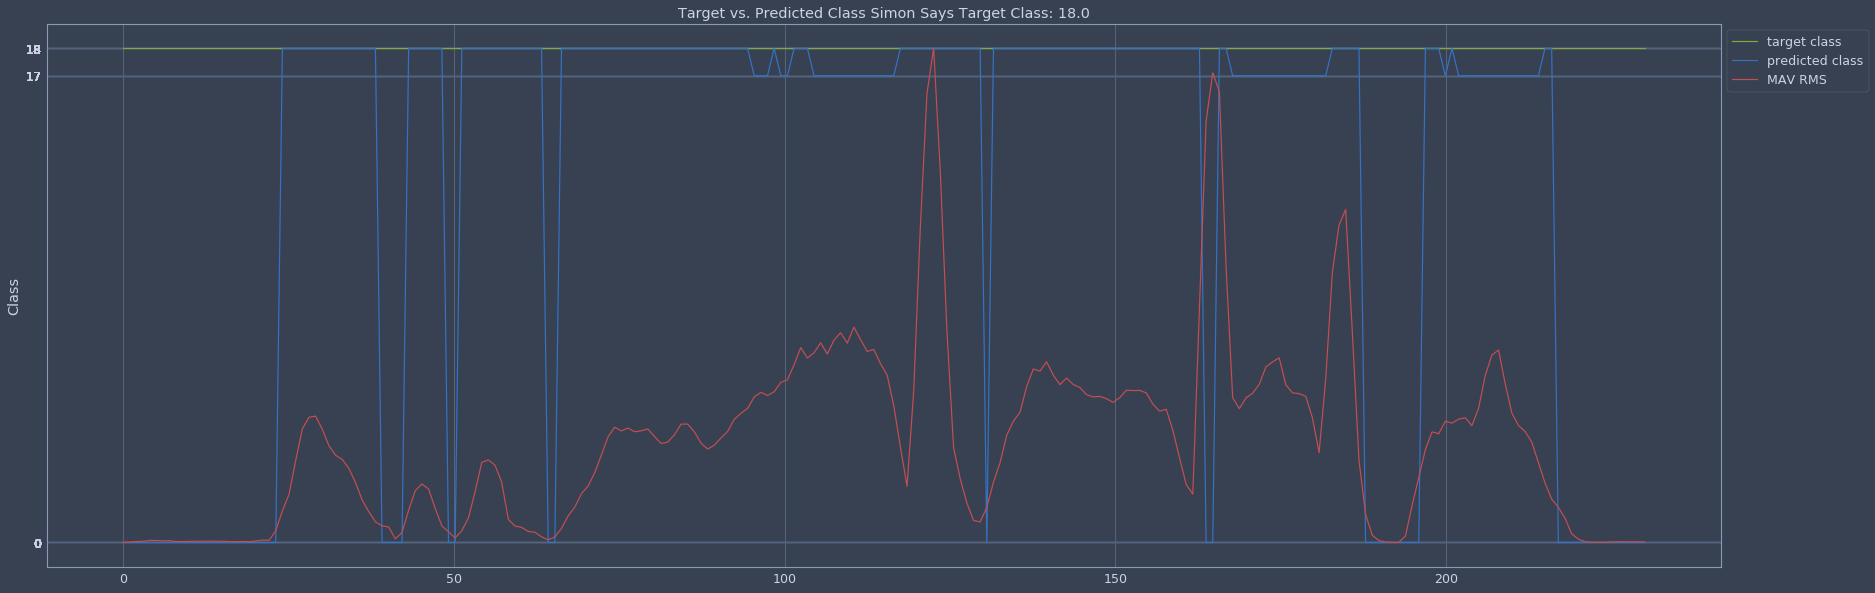

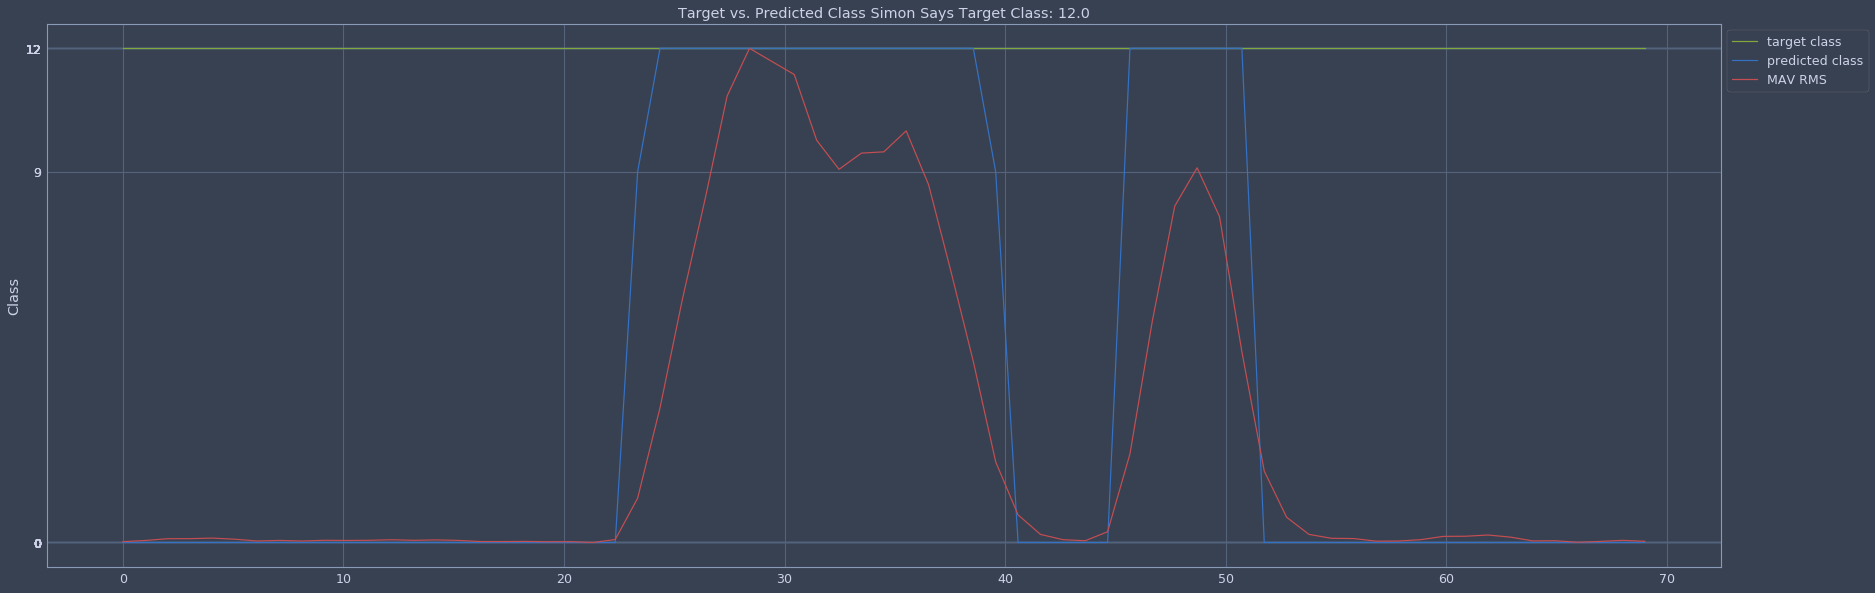

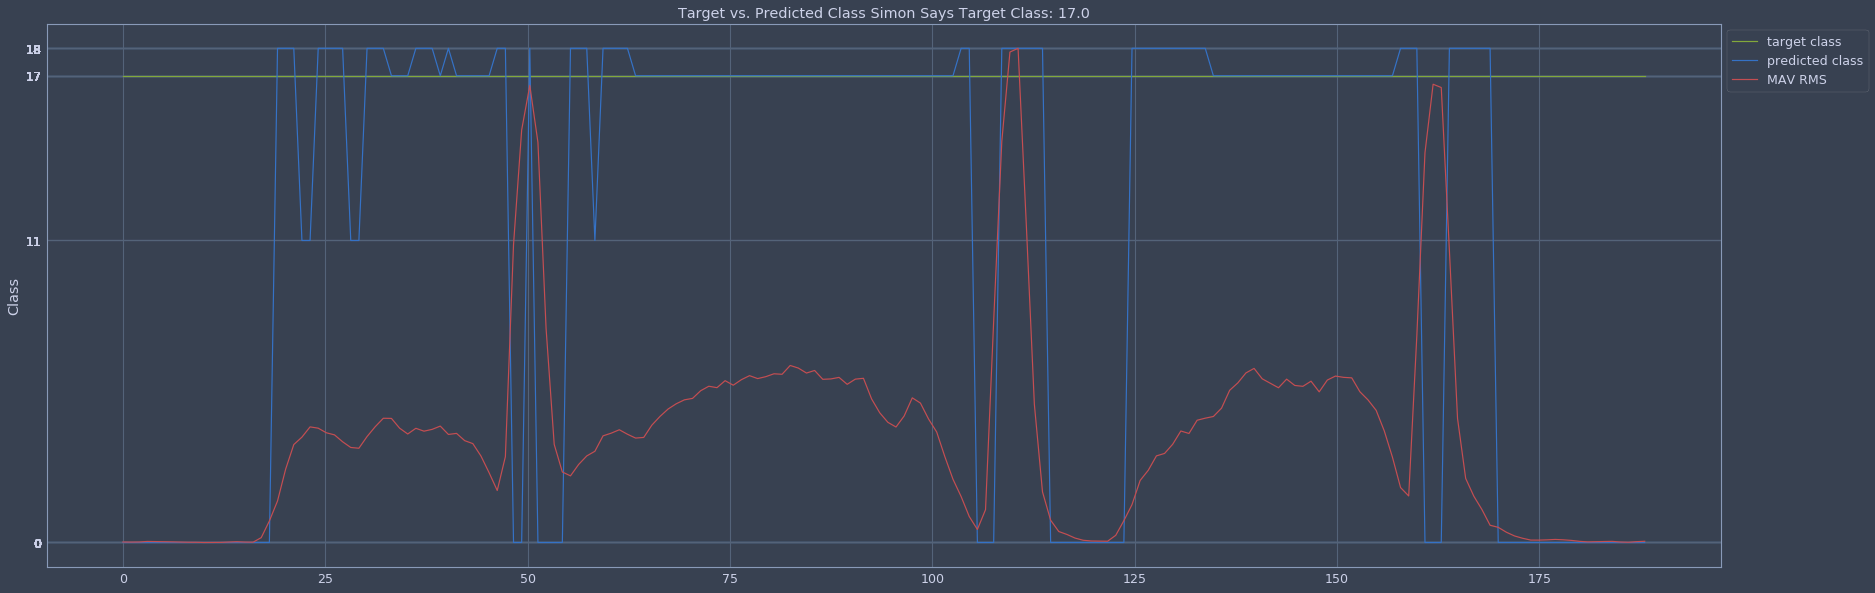

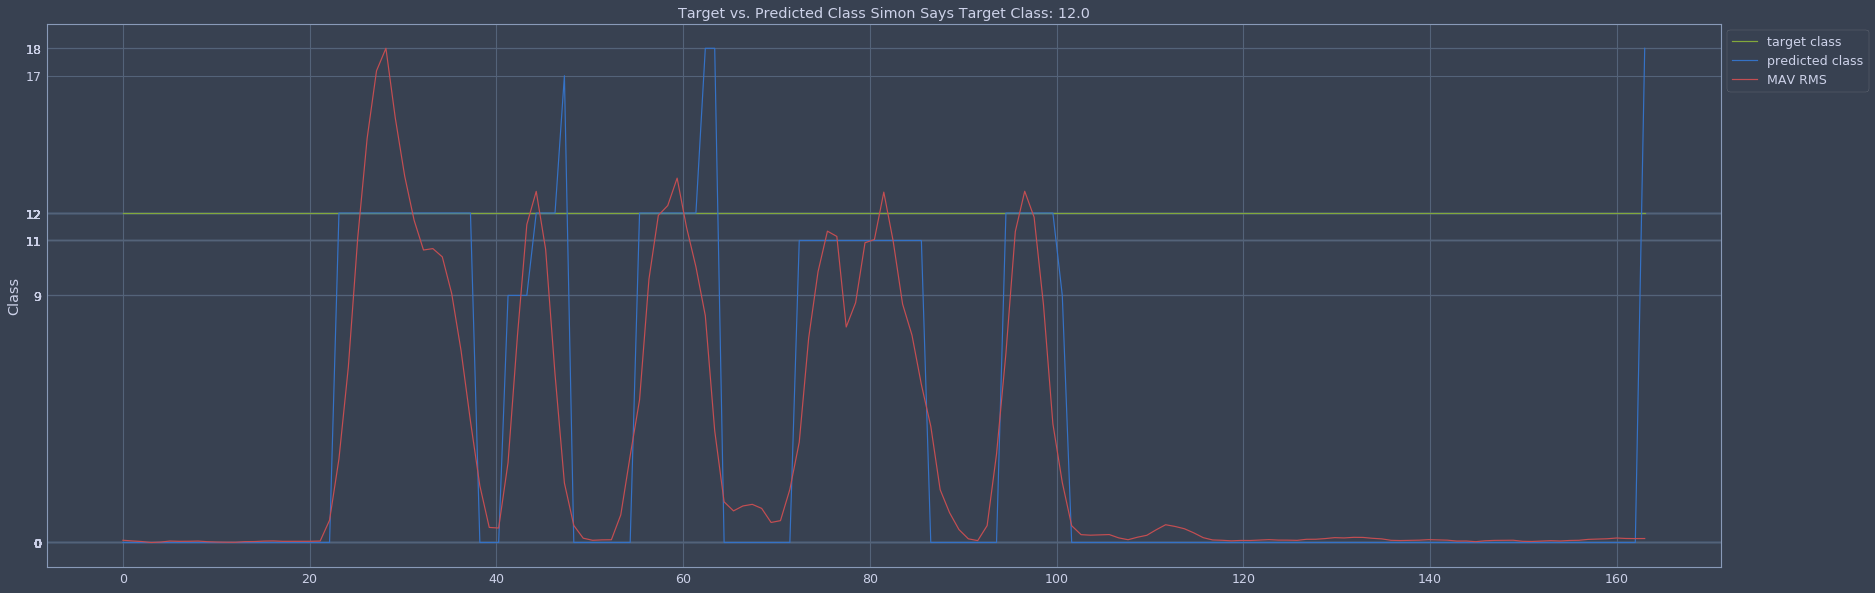

In [19]:
data = SimonSays[0]
values = target_vs_predicted_w_RMS(data)

# plot each set of target class with the predicted class
for value in values:
    plt.figure(figsize=(30,10))
    points = len(value)
    x = np.linspace(0, points, points)
    OldRange = (value[:,10].max() - value[:,10].min())
    NewRange = (value[:,0].max() - value[:,0].min())
    value[:,10] = (((value[:,10] - value[:,10].min()) * NewRange) / OldRange) + value[:,0].min()
    plt.plot(x, value[:,1], label='target class', color='g')
    plt.plot(x, value[:,0], label='predicted class', color='b')
    plt.plot(x, value[:,10], label='MAV RMS', color='r')
    plt.title(f"Target vs. Predicted Class Simon Says Target Class: {value[0,1]}")
    plt.ylabel("Class")
    plt.yticks(value[:,1])
    plt.yticks(value[:,0])
    plt.legend(bbox_to_anchor=(1, 1),loc='upper left')
    plt.show()

[[14, 14, 0], [3, 1, 1], [2, 1, 1], [2, 1, 1], [1, 2, 1], [4, 3, 1], [9, 3, 0], [6, 2, 1], [9, 10, 1], [3, 5, 0], [3, 5, 1], [4, 15, 1], [9, 1, 0], [1, 6, 0], [6, 13, 1], [2, 4, 0], [3, 9, 0], [5, 1, 0], [5, 8, 0], [2, 3, 1], [3, 23, 1], [5, 28, 0], [11, 8, 0], [6, 7, 0], [5, 4, 0], [6, 4, 0], [5, 3, 0], [6, 1, 0], [5, 16, 0], [2, 13, 1], [2, 3, 0], [20, 8, 0], [2, 1, 1], [13, 8, 0], [5, 18, 1], [3, 14, 0]]


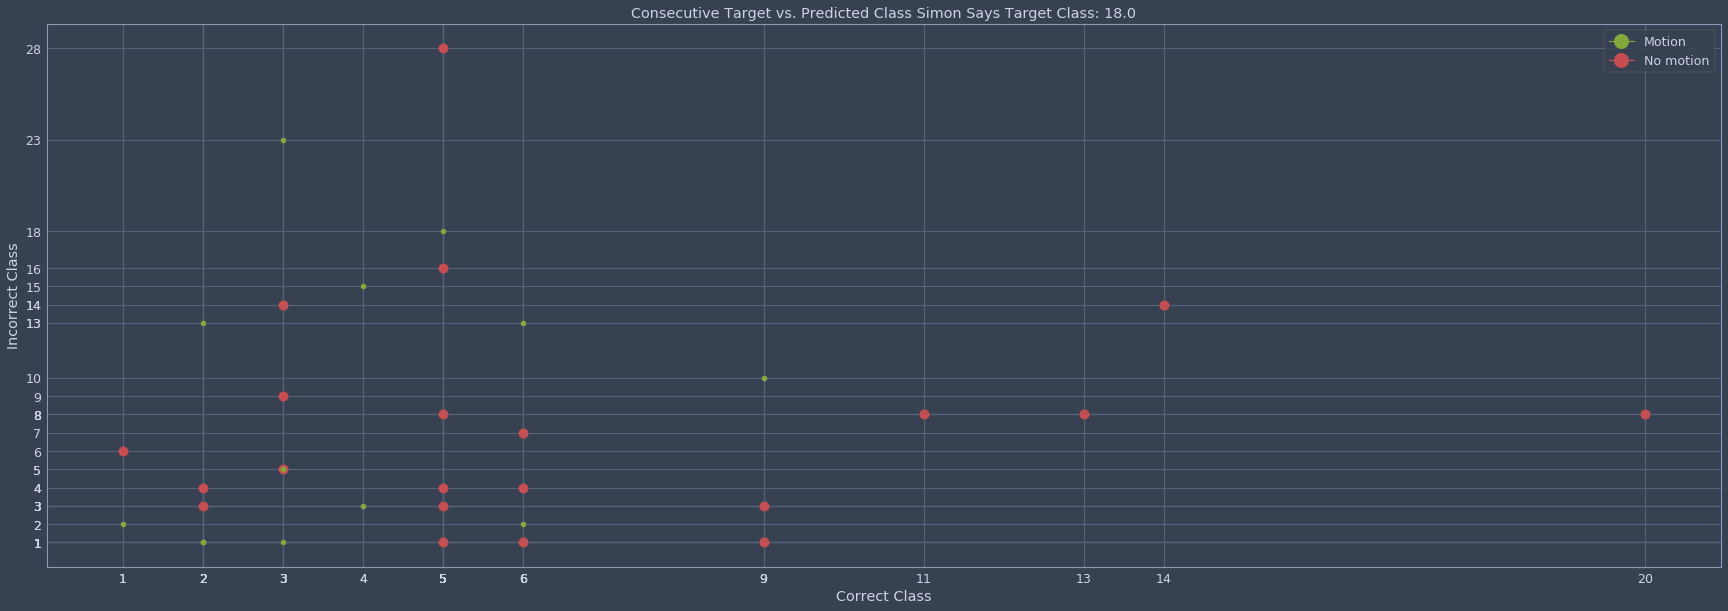

[[16, 9, 0]]


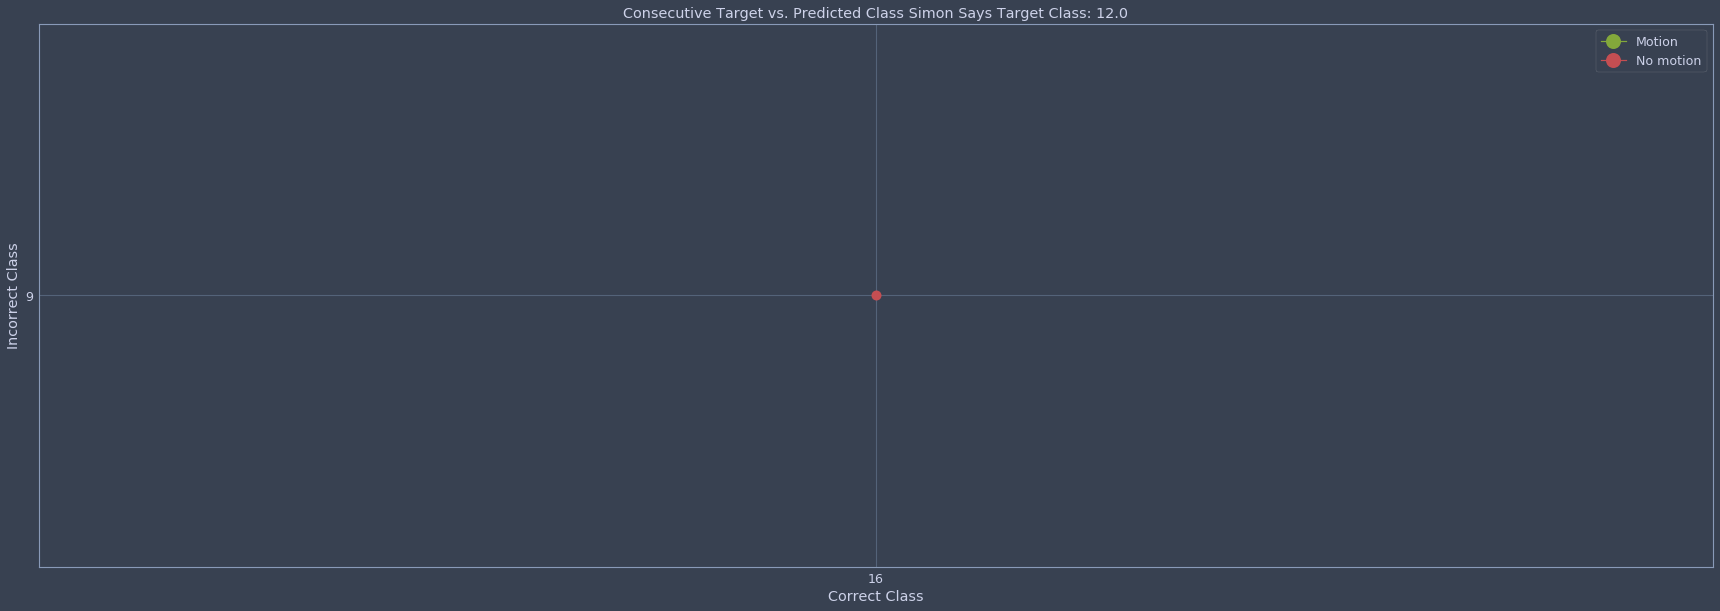

[[56, 11, 0]]


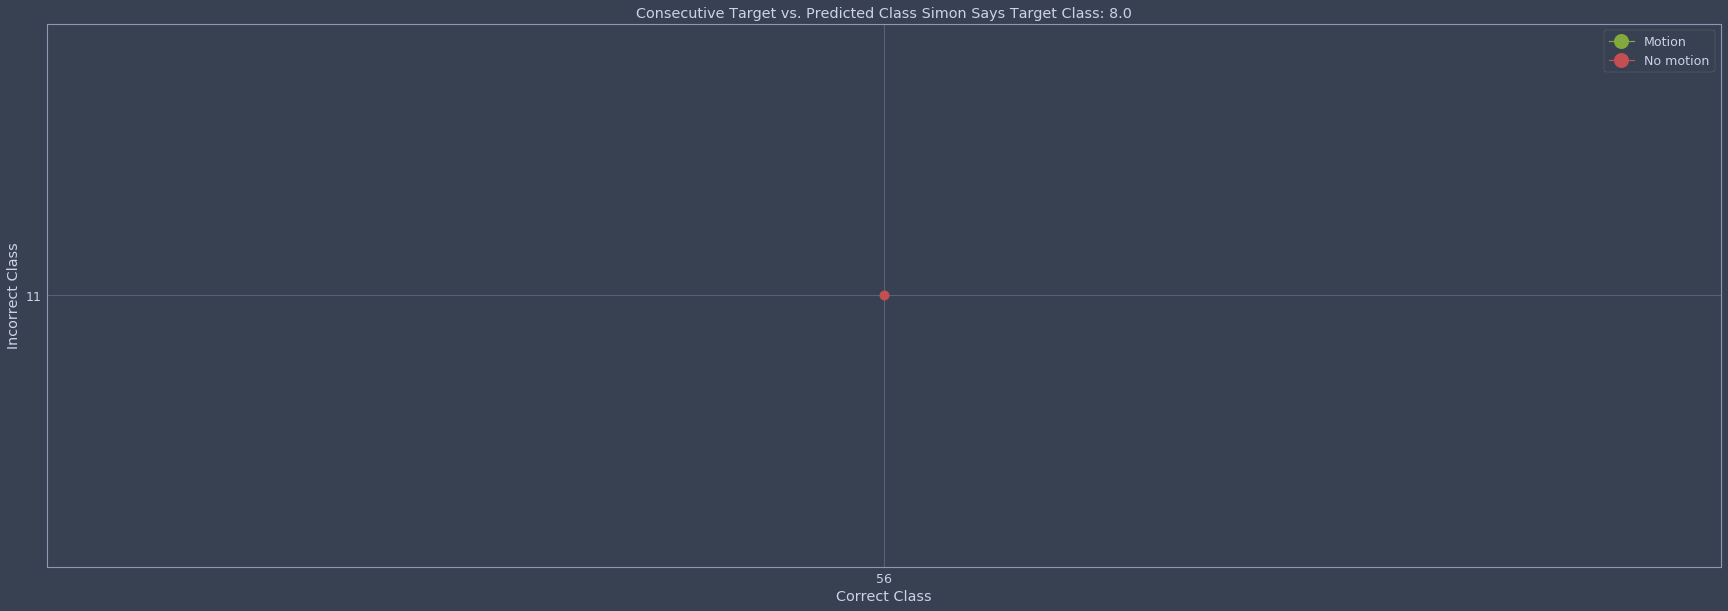

[[16, 18, 0]]


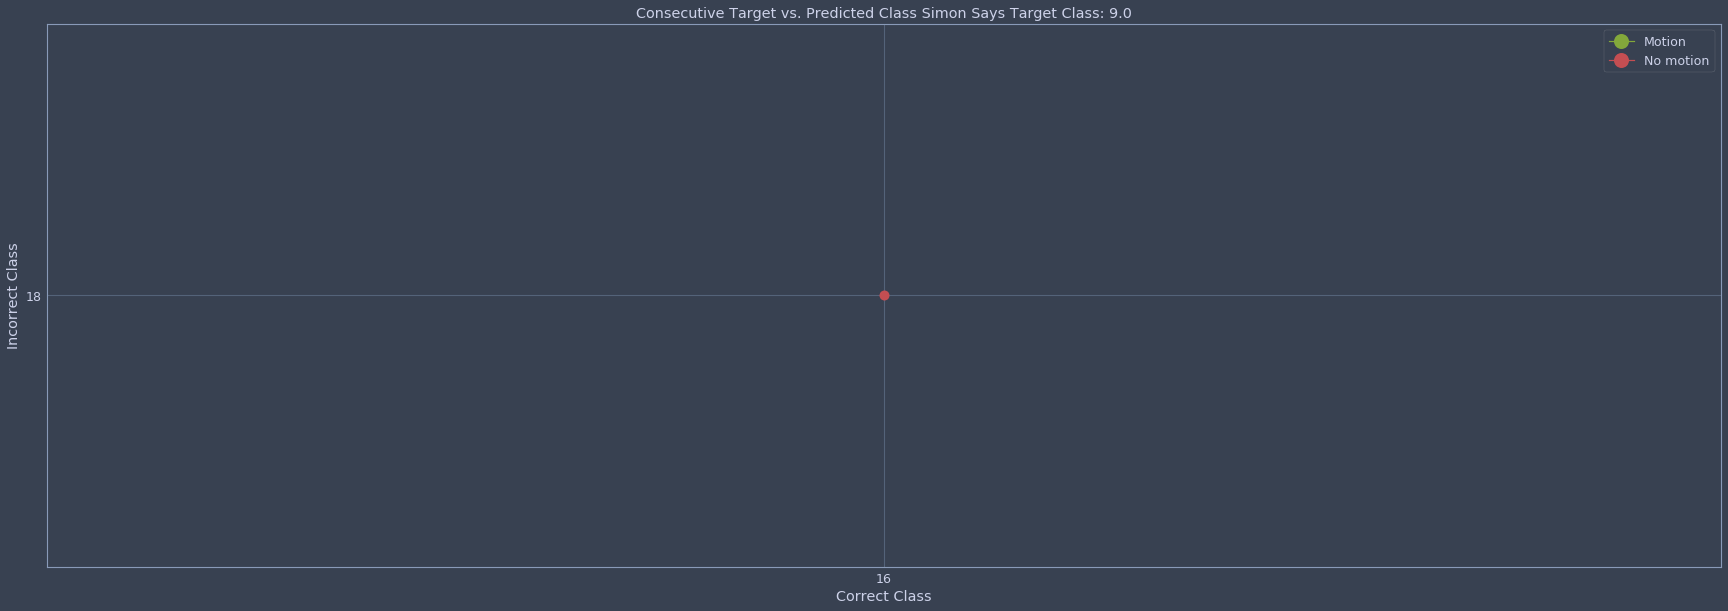

[[17, 2, 1], [9, 5, 1], [11, 3, 1]]


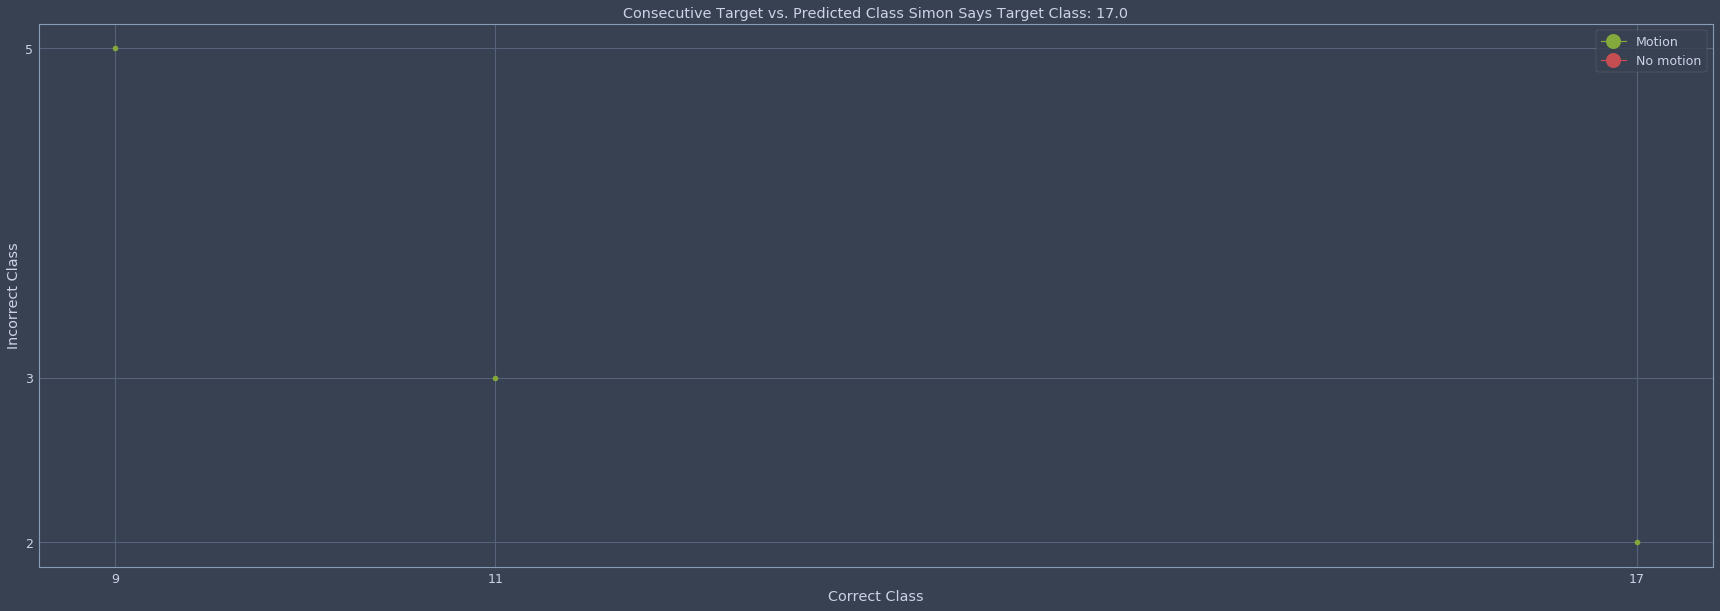

[[30, 12, 0]]


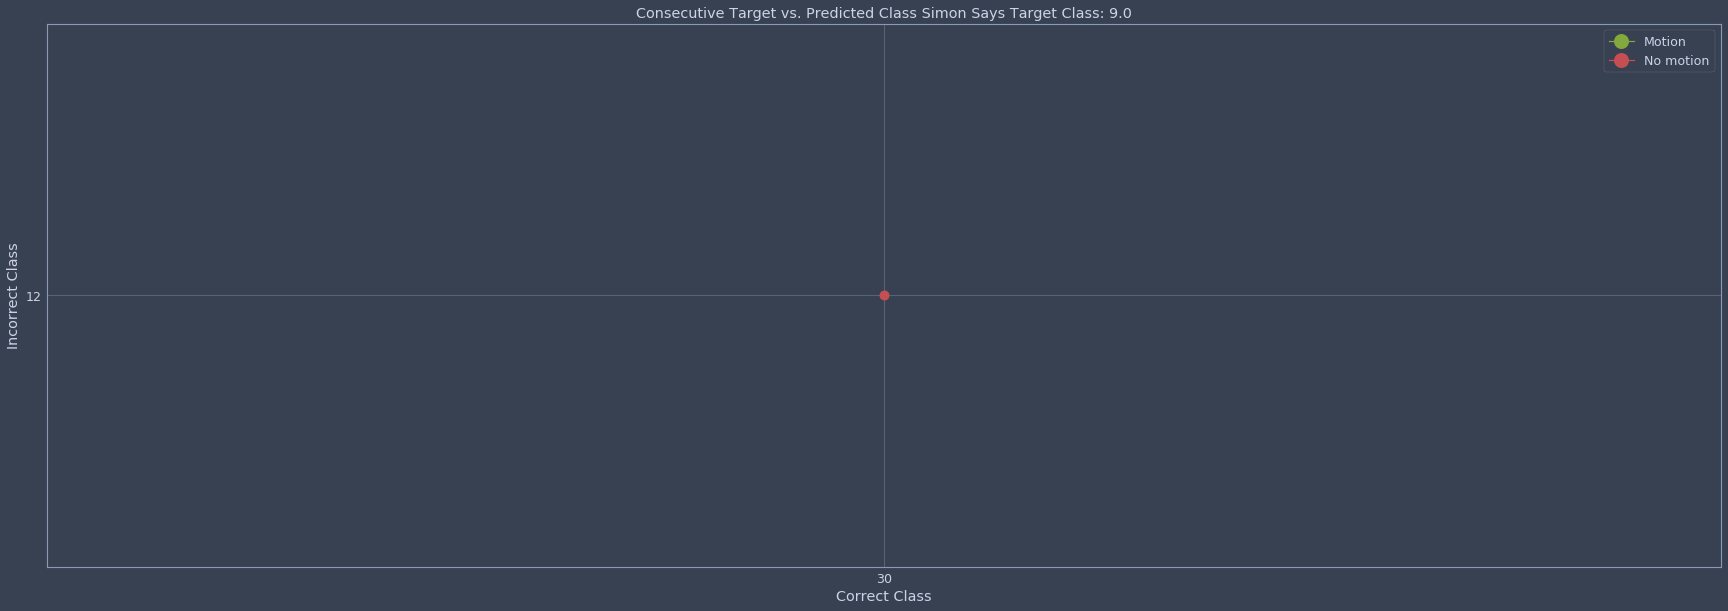

[[25, 3, 1]]


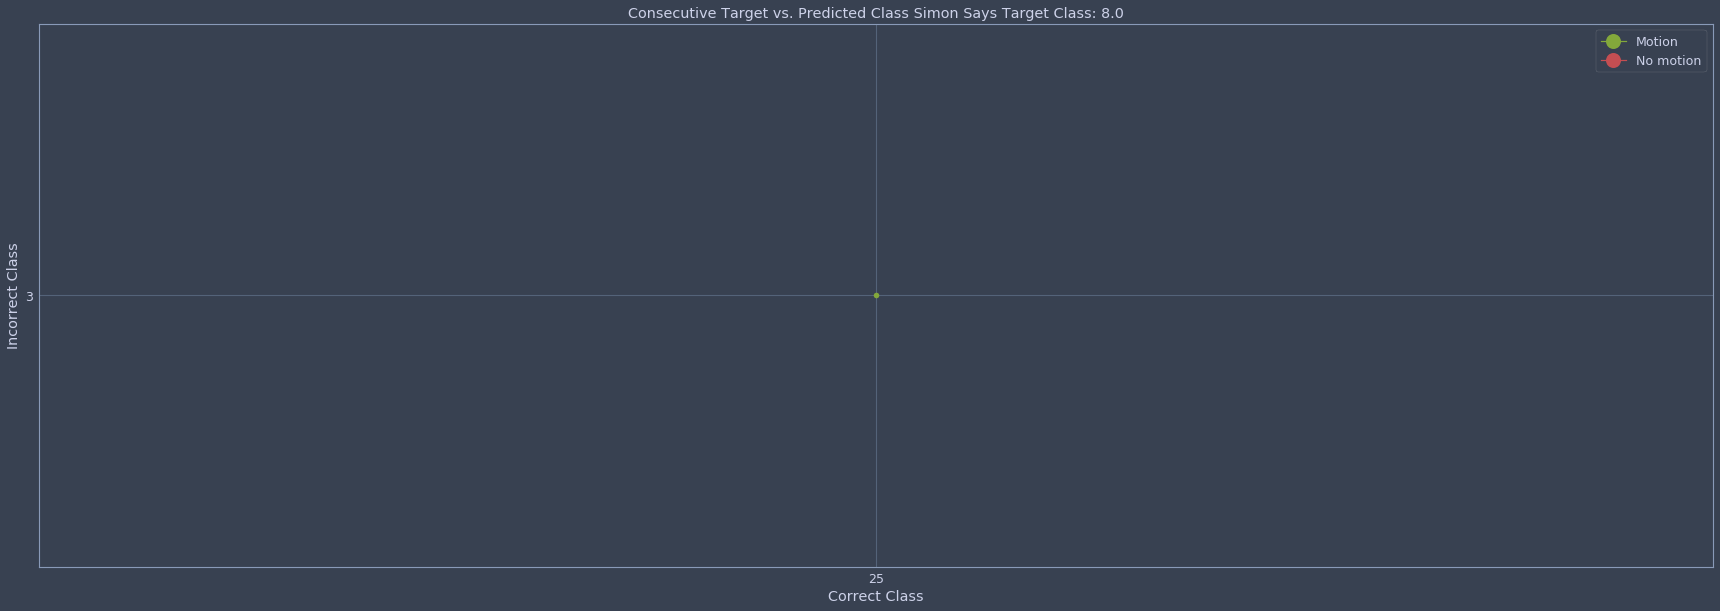

[[28, 19, 0]]


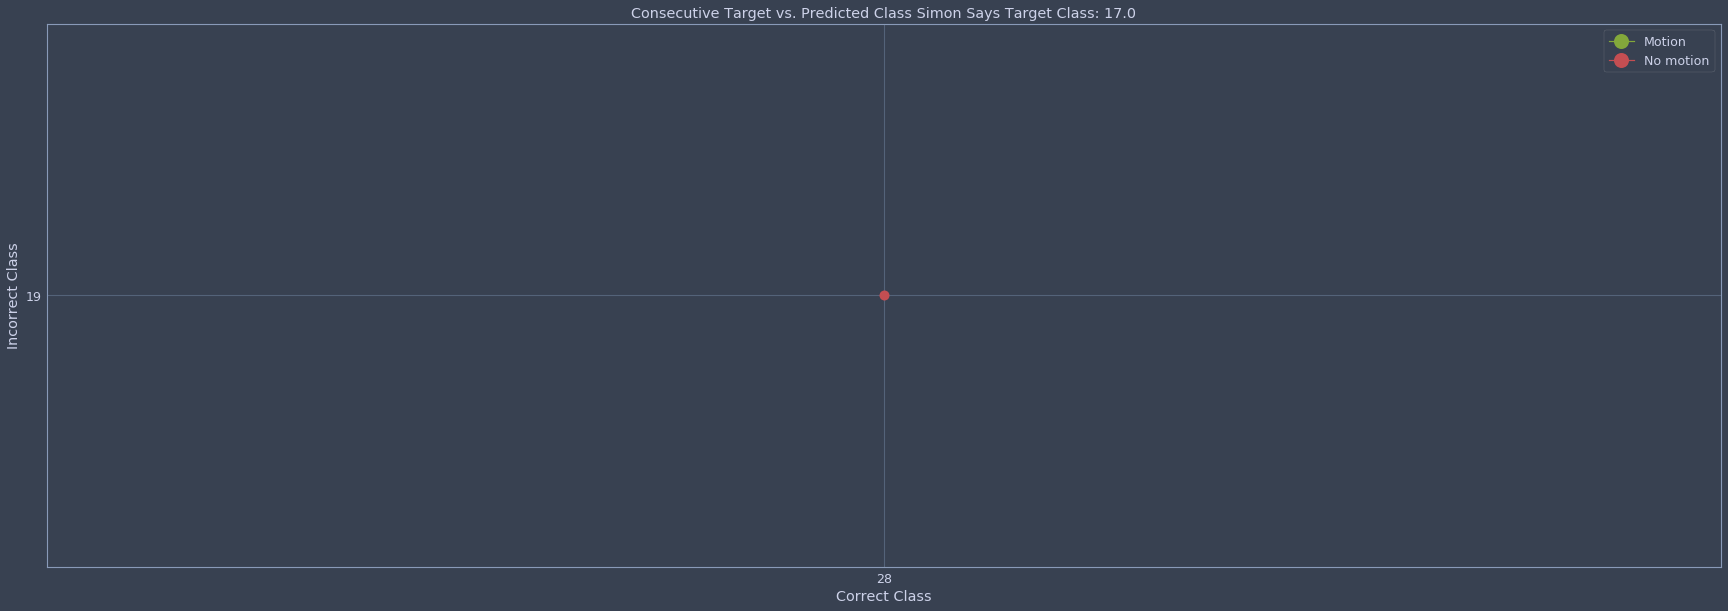

[[43, 12, 0]]


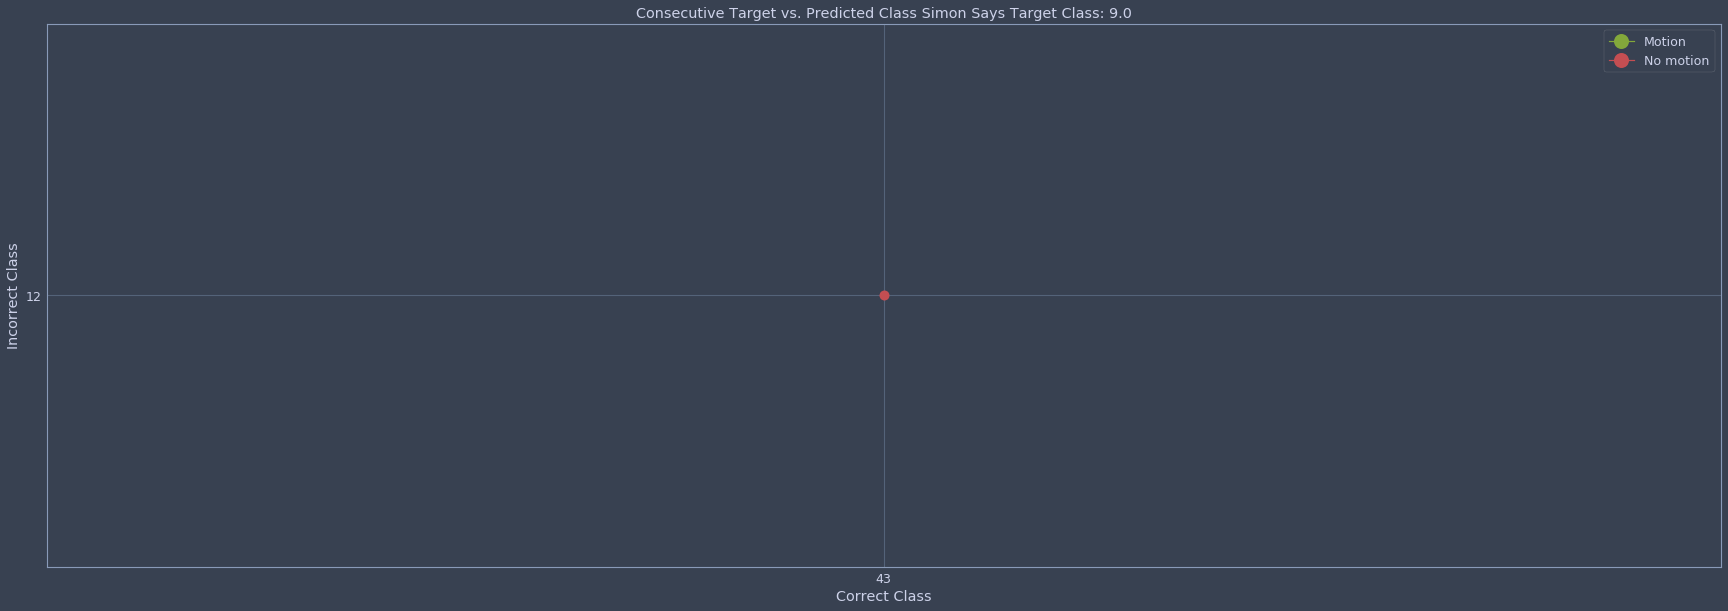

[[23, 6, 0], [5, 2, 0], [10, 50, 0], [20, 3, 0], [6, 1, 0], [1, 1, 1], [6, 2, 1]]


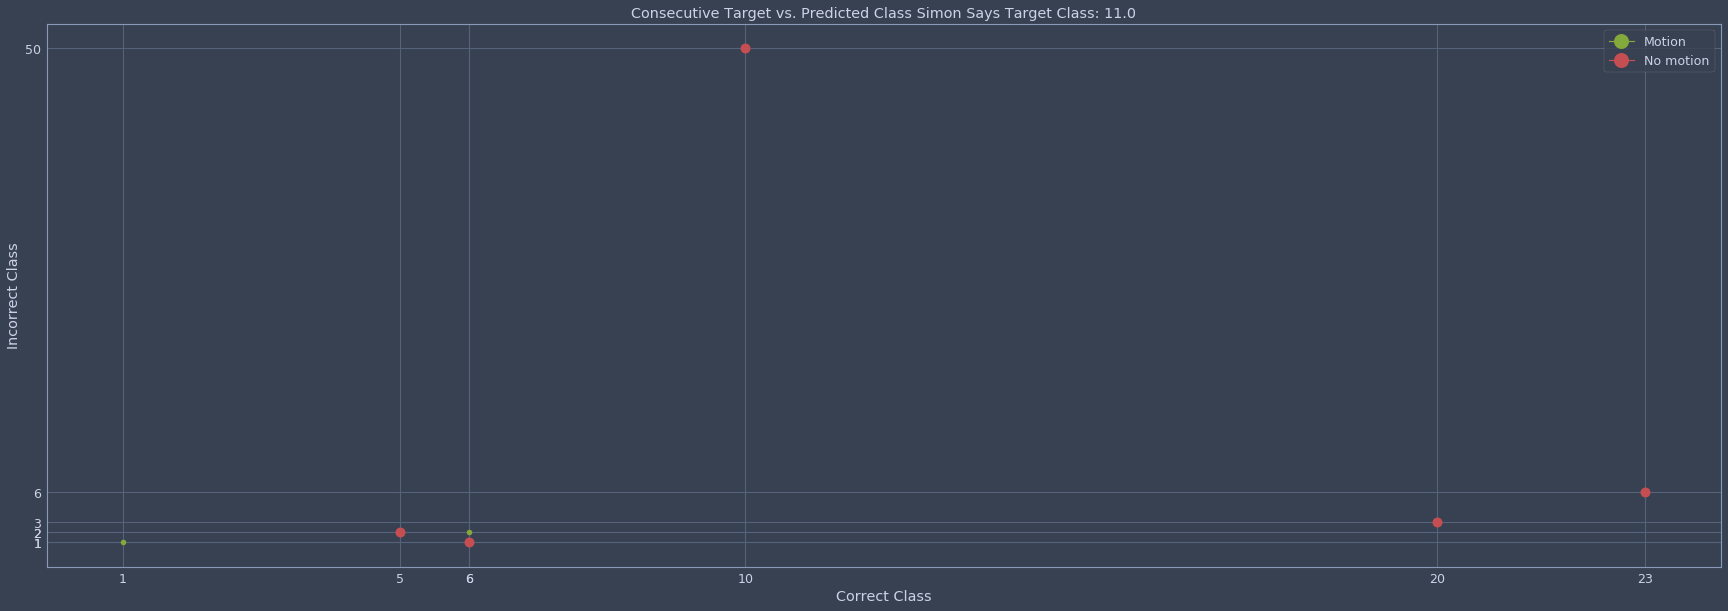

[[19, 1, 1]]


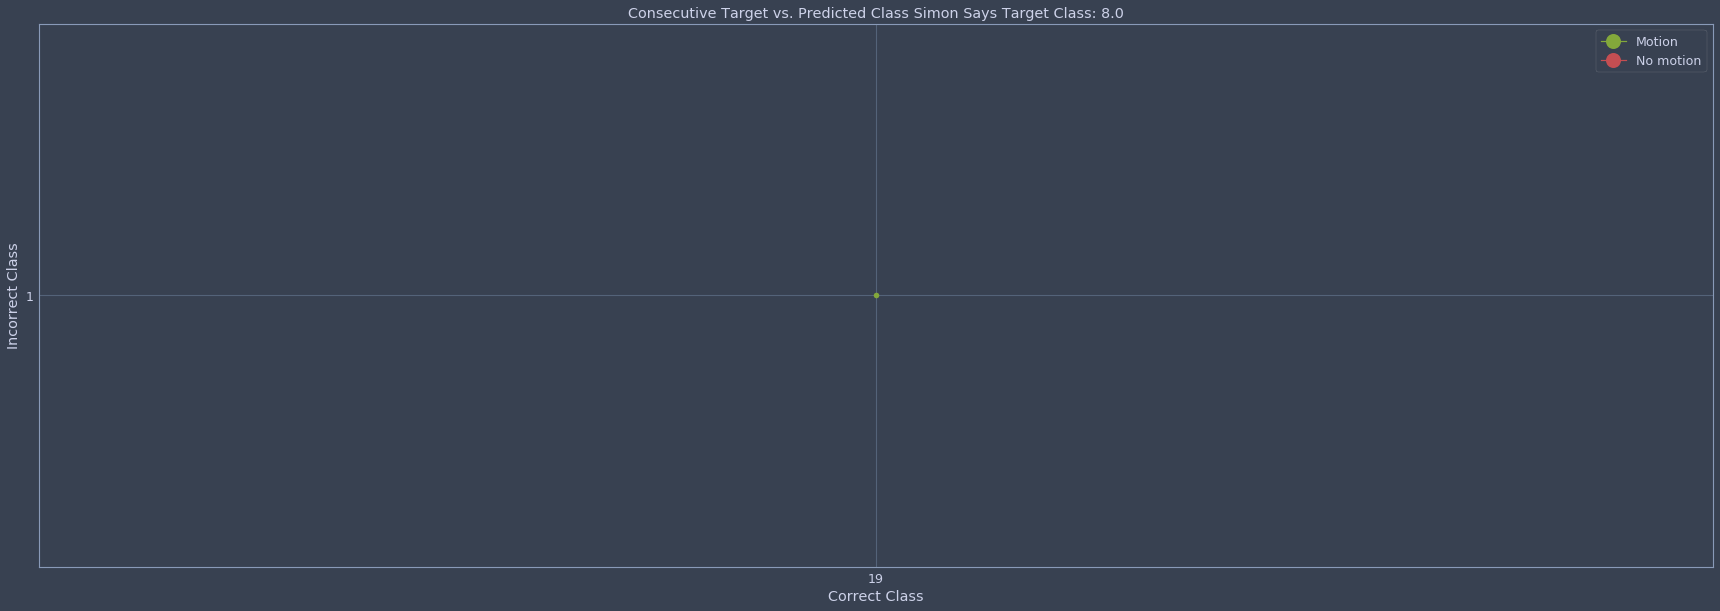

[[23, 4, 0], [6, 1, 1], [8, 17, 0]]


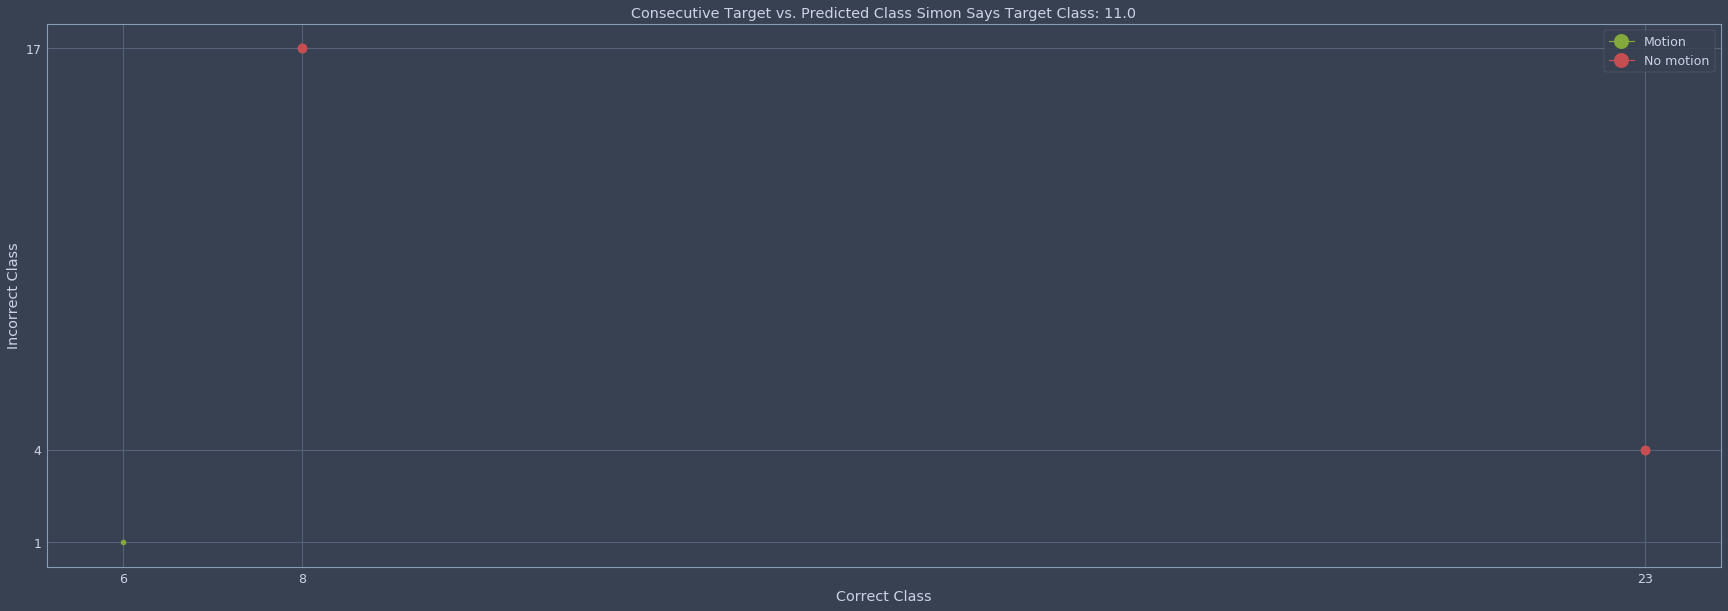

[[15, 4, 0], [6, 2, 0], [13, 2, 0], [29, 3, 1], [1, 2, 1], [3, 13, 1], [13, 1, 0], [32, 2, 0], [2, 15, 1], [5, 9, 0], [3, 1, 1], [1, 13, 1], [2, 14, 0]]


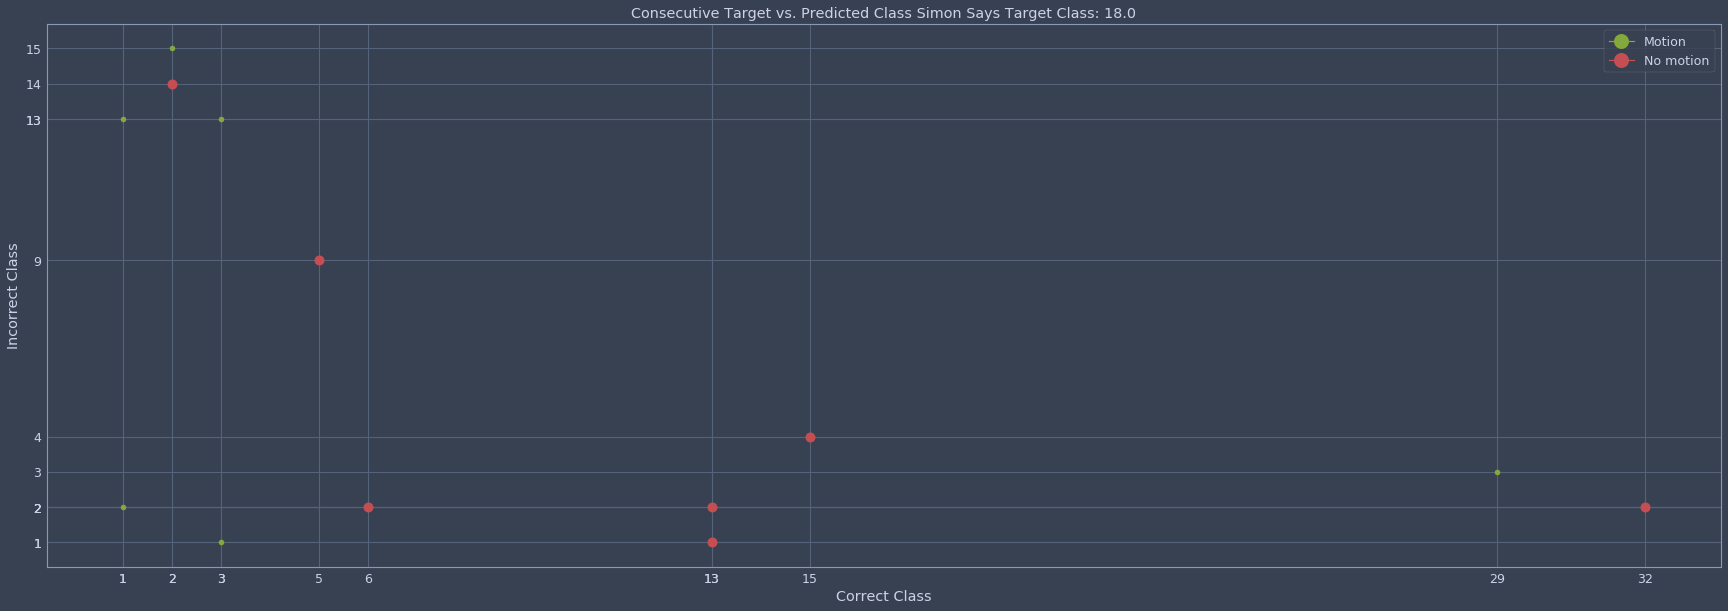

[[15, 1, 1], [6, 18, 0]]


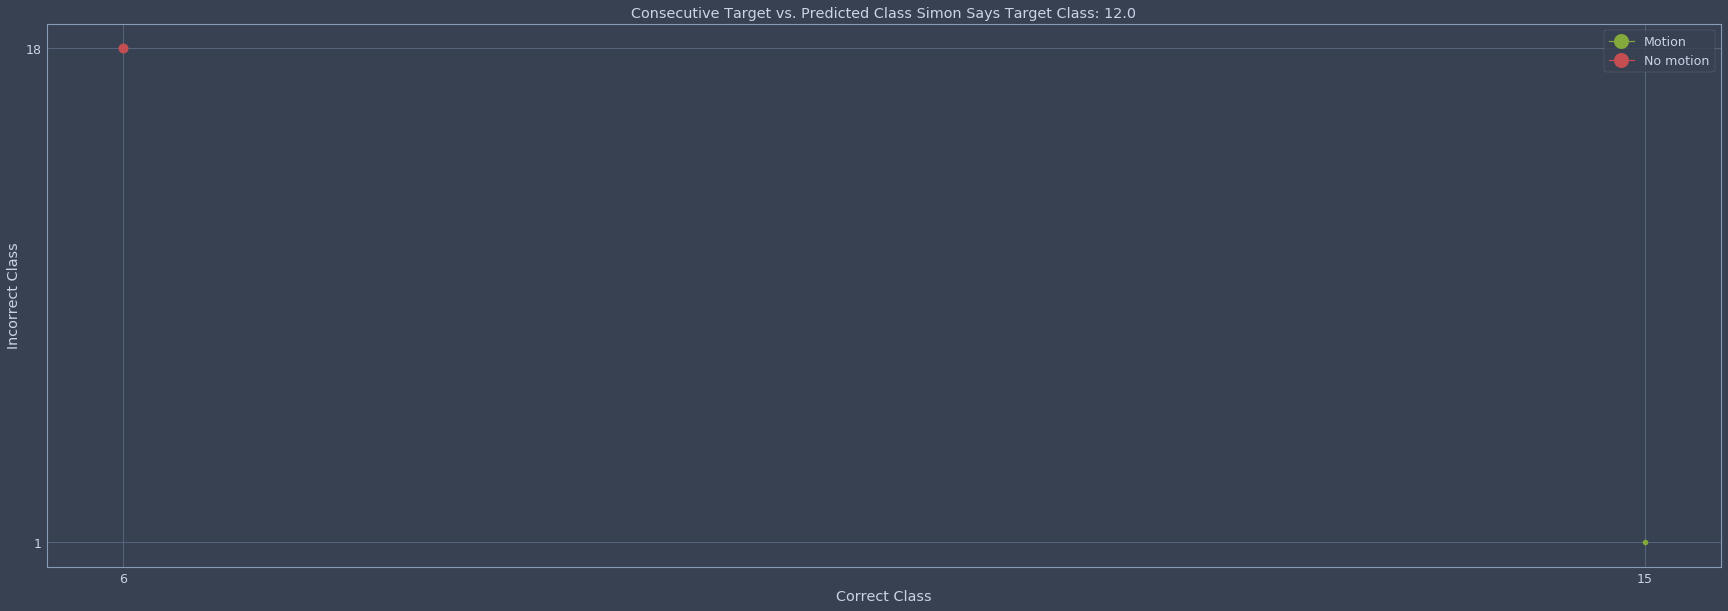

[[3, 3, 1], [1, 1, 1], [5, 2, 1], [40, 2, 1], [23, 3, 1]]


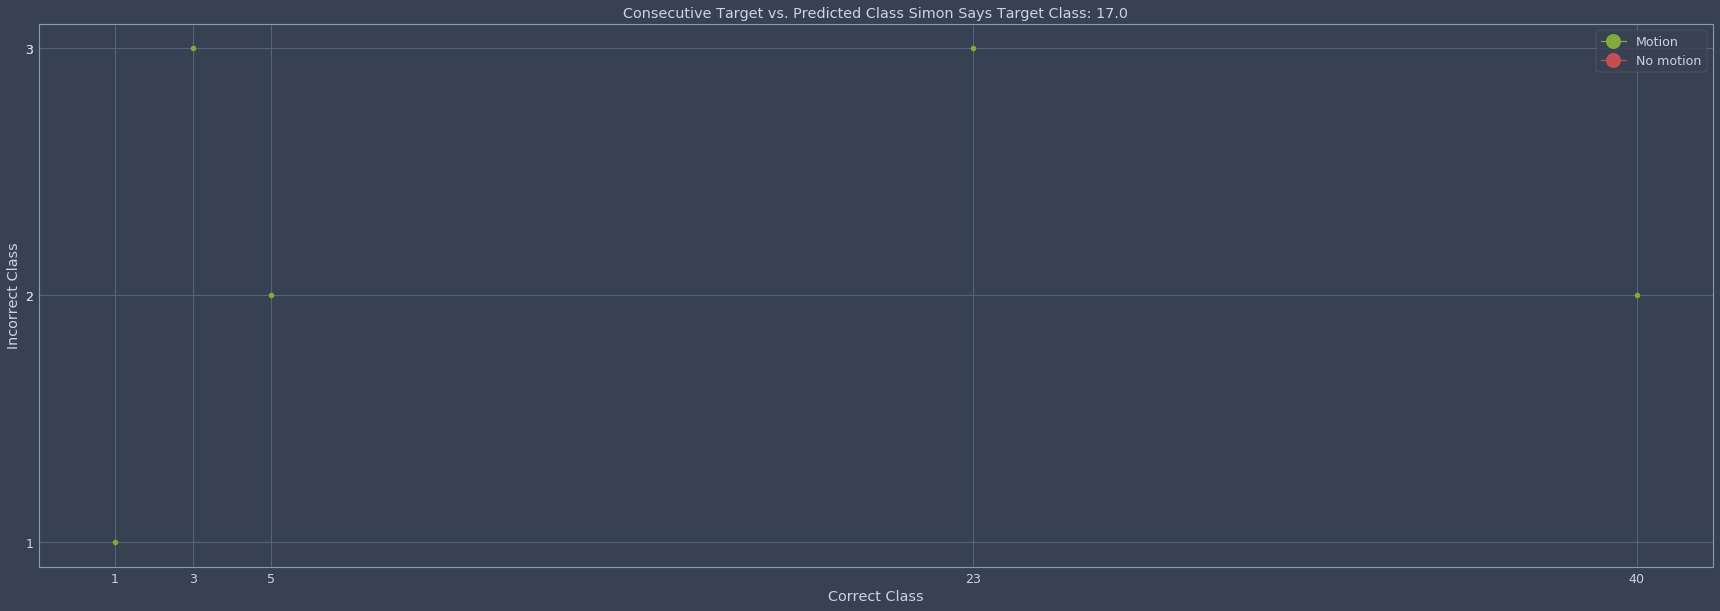

[[15, 3, 0], [3, 1, 1], [7, 2, 1], [6, 1, 1]]


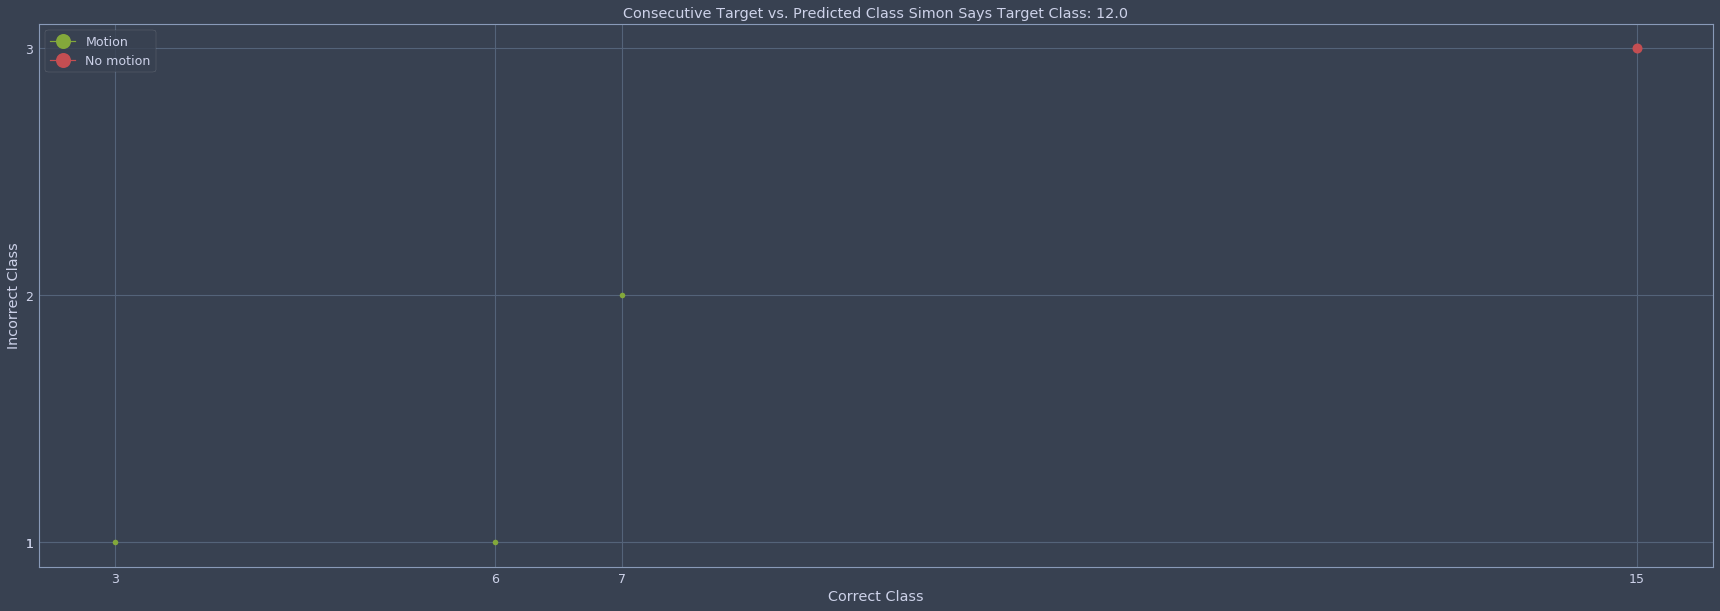

In [23]:
data = SimonSays[0]
consecutive_target_vs_predicted_SS(data)